# Подготовка

In [60]:
!pip install catboost

In [61]:
import numpy as np
import random
import time
import itertools
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from math import sqrt
from collections import defaultdict
from itertools import combinations, product, groupby
from imblearn.over_sampling import SMOTE

from scipy.special import gamma
from scipy.spatial.distance import pdist, squareform, euclidean
from scipy.stats import moment, entropy, kurtosis

from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier

from catboost import CatBoostClassifier

In [62]:
# data generation 
N = 5
WINDOW_MIN = 8
WINDOW = 15

TRAIN_SIZE = 5000
VAL_SIZE = 200
TEST_SIZE = 200
PTS = 100

train_start = 0
train_end = TRAIN_SIZE

val_init = TRAIN_SIZE + WINDOW - 1
val_start = val_init - 1
val_end = val_start + VAL_SIZE

val_sf_init = val_end + WINDOW - 1
val_sf_start = val_sf_init - 1
val_sf_end = val_sf_start + VAL_SIZE

test_init = val_sf_end + WINDOW - 1
test_start = test_init - 1
test_end = test_start + TEST_SIZE - WINDOW 

# clusterize data
WISHART_K = 4
WISHART_H = 0.2

# generate predictions
STEPS, EPS = 50, 0.05
Q_VALUE = 0.99

# Функции

### Генерация ряда Лоренца

In [63]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    #Differential equations of a Lorenz System
    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    #RK4 for the differential equations
    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        #Initial values and Parameters
        x_0, y_0, z_0 = 1, 1, 1

        #RK4 iteration
        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

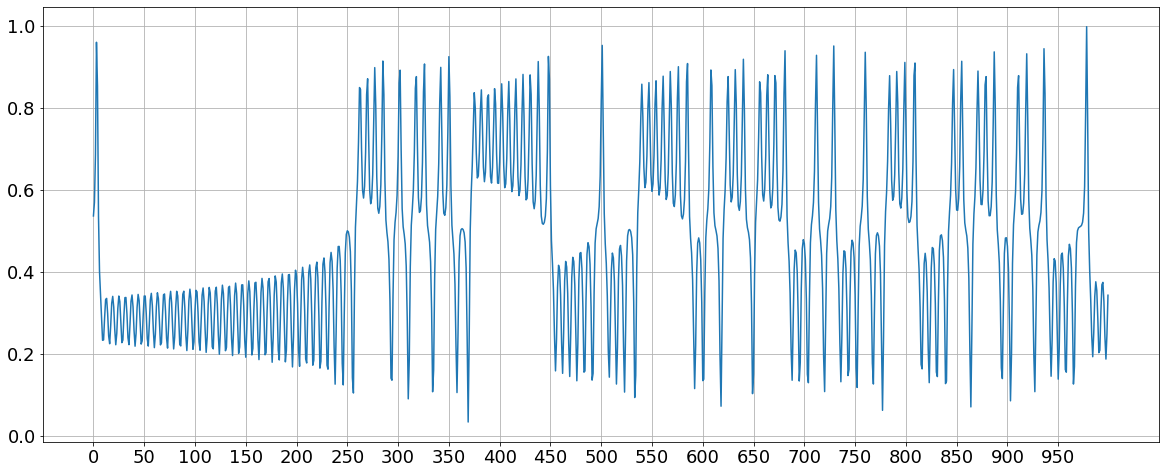

In [64]:
xs, _, _ = Lorentz().generate(0.1, 100000)
xs = (xs - xs.min()) / (xs.max() - xs.min())

x_train = xs[train_start:train_end]
x_val = xs[val_start:val_end]
x_val_sf = xs[val_sf_start:val_sf_end]
x_test = xs[test_start:test_end]

plt.figure(figsize=(20, 8))
plt.plot(xs[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

### Wishart clusterization

In [65]:
def volume(r, m):
    return np.pi ** (m / 2) * r ** m / gamma(m / 2 + 1)

def significant(cluster, h, p):
    max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))
    return max_diff >= h

def partition(dist, l, r, order):
    if l == r:
        return l

    pivot = dist[order[(l + r) // 2]]
    left, right = l - 1, r + 1
    while True:
        while True:
            left += 1
            if dist[order[left]] >= pivot:
                break

        while True:
            right -= 1
            if dist[order[right]] <= pivot:
                break

        if left >= right:
            return right

        order[left], order[right] = order[right], order[left]

def nth_element(dist, order, k):
    l, r = 0, len(order) - 1
    while True:
        if l == r:
            break
        m = partition(dist, l, r, order)
        if m < k:
            l = m + 1
        elif m >= k:
            r = m

def get_clustering(x, k, h, verbose=True):
    n = len(x)
    if isinstance(x[0], list):
        m = len(x[0])
    else:
        m = 1
    dist = squareform(pdist(x))

    dk = []
    for i in range(n):
        order = list(range(n))
        nth_element(dist[i], order, k - 1)
        dk.append(dist[i][order[k - 1]])


    p = [k / (volume(dk[i], m) * n) for i in range(n)]

    w = np.full(n, 0)
    completed = {0: False}
    last = 1
    vertices = set()
    for d, i in sorted(zip(dk, range(n))):
        neigh = set()
        neigh_w = set()
        clusters = defaultdict(list)
        for j in vertices:
            if dist[i][j] <= dk[i]:
                neigh.add(j)
                neigh_w.add(w[j])
                clusters[w[j]].append(j)

        vertices.add(i)
        if len(neigh) == 0:
            w[i] = last
            completed[last] = False
            last += 1
        elif len(neigh_w) == 1:
            wj = next(iter(neigh_w))
            if completed[wj]:
                w[i] = 0
            else:
                w[i] = wj
        else:
            if all(completed[wj] for wj in neigh_w):
                w[i] = 0
                continue
            significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], h, p))
            if len(significant_clusters) > 1:
                w[i] = 0
                for wj in neigh_w:
                    if wj in significant_clusters:
                        completed[wj] = (wj != 0)
                    else:
                        for j in clusters[wj]:
                            w[j] = 0
            else:
                if len(significant_clusters) == 0:
                    s = next(iter(neigh_w))
                else:
                    s = next(iter(significant_clusters))
                w[i] = s
                for wj in neigh_w:
                    for j in clusters[wj]:
                        w[j] = s
    return w

In [66]:
class WishartClusterization(object):
    def __init__(self, k, h):
        self.k = k
        self.h = h
        
    
    def fit(self, x):
        n = len(x)
        if isinstance(x[0], list):
            m = len(x[0])
        else:
            m = 1
        dist = squareform(pdist(x))

        dk = []
        for i in range(n):
            order = list(range(n))
            nth_element(dist[i], order, self.k - 1)
            dk.append(dist[i][order[self.k - 1]])


        p = [self.k / (volume(dk[i], m) * n) for i in range(n)]

        w = np.full(n, 0)
        completed = {0: False}
        last = 1
        vertices = set()
        for d, i in sorted(zip(dk, range(n))):
            neigh = set()
            neigh_w = set()
            clusters = defaultdict(list)
            for j in vertices:
                if dist[i][j] <= dk[i]:
                    neigh.add(j)
                    neigh_w.add(w[j])
                    clusters[w[j]].append(j)

            vertices.add(i)
            if len(neigh) == 0:
                w[i] = last
                completed[last] = False
                last += 1
            elif len(neigh_w) == 1:
                wj = next(iter(neigh_w))
                if completed[wj]:
                    w[i] = 0
                else:
                    w[i] = wj
            else:
                if all(completed[wj] for wj in neigh_w):
                    w[i] = 0
                    continue
                significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], self.h, p))
                if len(significant_clusters) > 1:
                    w[i] = 0
                    for wj in neigh_w:
                        if wj in significant_clusters:
                            completed[wj] = (wj != 0)
                        else:
                            for j in clusters[wj]:
                                w[j] = 0
                else:
                    if len(significant_clusters) == 0:
                        s = next(iter(neigh_w))
                    else:
                        s = next(iter(significant_clusters))
                    w[i] = s
                    for wj in neigh_w:
                        for j in clusters[wj]:
                            w[j] = s
        self.labels_ = w
        return self

### Генерация центров кластеров

In [67]:
def generate_centers(x_trains, WISHART_K=4, WISHART_H=0.2): 
    ws = {}
    for pattern, train in x_trains.items():
        ws[pattern] = get_clustering(train, WISHART_K, WISHART_H) 
    centers = {}
    
    for pattern, w in ws.items():
        sorted_by_cluster = sorted(range(len(w)), key=lambda x: w[x])
        for wi, cluster in groupby(sorted_by_cluster, lambda x: w[x]):
            cluster = list(cluster)
            center = np.full(N, 0.0)
            for i in cluster:

                center += x_trains[pattern][i]
            centers.setdefault(pattern, []).append(center / len(cluster))

    return centers

### Генерация паттернов

In [68]:
def generate_subsequences(window, num, short=False): 
    values = list(range(window))
    result = []
    if short:
        for subseq in itertools.combinations(values, num):
            diff = WINDOW - WINDOW_MIN 
            result.append(tuple([num + diff for num in subseq]))
    else:
        for subseq in itertools.combinations(values, num):
            result.append(subseq)
    
    return result

### Подстановка паттернов

In [69]:
def str_subseq(subseq):
    if not subseq:
        return '<None>'
    return ','.join(map(str, subseq))

def gen_sample_in_point(values, window, pattern, pos): 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None

def gen_sample_in_point_with_q(values, window, pattern, pos): 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos][0] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val[0] == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None
    
def generate_sample(values, window, pattern, put_none=False): 
    result = []
    for i in range(len(values)):
        res = gen_sample_in_point(values, window, pattern, i)
        if res == None:
            if put_none:
                result.append(res)
        else:
            result.append(res)
    return result

def aggr(pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts)) 
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

### Функция предсказания

In [70]:
def generate_predictions(centers, deamon=None, return_set_pred=False, real_mode='test',
                          EPS=0.05, Q_VALUE=0.99):
    preds = {}
    set_preds = {}

    if real_mode == 'test':
        end_point = val_end
        init_point = test_init
    else:
        end_point = train_end
        init_point = val_init

    for start_point in tqdm(range(PTS)):
        
        # initialize empty
        preds[start_point] = [None] * (start_point + 1)
        if return_set_pred:
            set_preds[start_point] = [None] * (start_point + 1)

        # current window
        wind = list(map(lambda x: (x, 1), xs[end_point + start_point : init_point + start_point]))

        for step in range(1, STEPS + 1):
            x_tests_for_point = {}
            for pattern in patterns:
                
                key = str_subseq(pattern + (WINDOW - 1,)) 
                sample = gen_sample_in_point_with_q(np.concatenate([wind, [(0, 0)]]), 
                                                    WINDOW, pattern, len(wind))
                if not sample:
                    x_tests_for_point[key] = None
                else:
                    x_tests_for_point[key] = sample

            chosen_centers = []
            for pattern, centers_values in centers.items():
                if not x_tests_for_point[pattern]:
                    continue
                vector = np.array(x_tests_for_point[pattern][:-1])[:, 0]
                q_values = np.array(x_tests_for_point[pattern][:-1])[:, 1]

                for center in centers_values:
                    dist = euclidean(vector, center[:-1])
                    if dist < EPS:
                        weight_d = (EPS - dist) / EPS
                        weight_q = np.mean(q_values) * Q_VALUE
                        chosen_centers.append((pattern, center, weight_d, weight_q))

            last_points = list(map(lambda center: (center[1][-1], center[2], center[3], center[0]), 
                                  chosen_centers))
            
            # deamon predict
            result_point = deamon.predict(start_point, step, last_points)
            preds[start_point].append(result_point)

            if return_set_pred:
                set_preds[start_point].append(last_points)

            
            if result_point:
                q_value = np.mean(np.array(list(map(lambda center: center[2], 
                                  chosen_centers))))
            else:
                q_value = None
            
            # move the window
            wind = np.concatenate([wind[1:], [(result_point, q_value)]])

    deamon.predicted = True

    if return_set_pred:
        return preds, set_preds
    return preds

### Визуализация результатов на участке ряда

In [71]:
def visualize_point(preds, point, real_vals=x_test, plot_all_points=None, plot_tube_points=None,
                    highlight_point=None, plot_res_tube=None, offset=3):
    plt.figure(figsize=(20, 8))
    colors=['green', 'red', 'orange']

    limits_real = [point - offset, point + STEPS + offset]
    plt.plot(
        range(limits_real[0], limits_real[1]),
        real_vals[limits_real[0]:limits_real[1]], 
        label='real values'
    )

    limits_predictions = [point, point + STEPS]
    for i, pred in enumerate(preds):
        plt.plot(
            range(limits_predictions[0], limits_predictions[1]),
            pred[0].get_predictions()[point][limits_predictions[0]:limits_predictions[1]], 
            label=pred[1], 
            marker='o', 
            markersize=2,
            c=colors[i]
        )

        if plot_all_points:
            for step in plot_all_points:
                raw_preds = pred[0].get_set_predictions()[point][point + step]
                set_preds = list(map(lambda x: x[0], raw_preds))
                plt.scatter([point + step for i in range(len(set_preds))], 
                            set_preds, alpha=0.2, color='red')
    if highlight_point:
        plt.plot(
            point + highlight_point,
            pred[0].get_predictions()[point][point + highlight_point], 
            label='bad', 
            marker='o', 
            markersize=10, 
            color="purple"
        )

    if plot_res_tube is not None:
        plt.plot(range(limits_predictions[0] + 1, limits_predictions[1] + 1), plot_res_tube, label='tube avg')

    if plot_tube_points is not None:
        for tr in plot_tube_points:
            plt.plot(range(limits_predictions[0] + 1, limits_predictions[1] + 1), tr, alpha=0.3, linestyle='--')

    

    plt.scatter([point], real_vals[point], label='start')
    plt.axvline(x=(point + 1), linewidth=0.5, color='r', label="step 1")
    for mark in range(5, STEPS + 1, 5):
        plt.axvline(x=(point + mark), linewidth=0.5, color='r', label="step " + str(mark))

    plt.title("Divergence")
    plt.xlabel("point")
    plt.ylabel("Lorenz value")
    plt.legend()

### Классы алгоритмов

In [72]:
class SimpleDeamon(object): # не использует дополнительные методы определения непрогнозируемых точек
    def __init__(self, mode='simple'):
        self.mode = mode
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}

        self.predicted = False
        
    @property
    def label(self):
        return 'Simple model of demon with ' + self.mode + ' mode'

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)
        if self.mode == 'simple':
            pred = simple_aggr(preds)
        elif self.mode == 'd_weighted':
            pred = aggr_d(preds)
        elif self.mode == 'q_weighted':
            pred = aggr_q(preds)
        elif self.mode == 'mix':
            pred = aggr_mix(preds)

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    def is_predicted(self):
        return self.predicted

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

In [73]:
class IdealDeamon(object): # сравнивает единое прогнозное значение с истинным
    def __init__(self, eps=0.05, mode='simple', real_vals=x_test):
        self.eps = eps
        self.mode = mode 
        self.real_vals=real_vals
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        
    @property
    def label(self):
        return 'Ideal model of demon'

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)
        pred, _, _ = get_weights(start_point, step, self.mode, self.set_predictions)
        if not pred or abs(pred - self.real_vals[start_point + step]) > self.eps:
            pred = None

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
       return self.predictions
    
    def get_set_predictions(self):
       return self.set_predictions

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

In [74]:
class MLDemon(object): #использует МО для определения непрогнозируемых точек
    def __init__(self, clf, stats, scaler, ensemble=False):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.clf = clf
        self.stats = stats
        self.scaler = scaler
        self.ensemble = ensemble
        
    @property
    def label(self):
        return self.stat.label()

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)
        if not preds:
            pred = None 
            self.predictions[start_point].append(pred)
            return pred
        
        pred, preds, weights = get_weights(start_point, step, 'mix', self.set_predictions)
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1)) 

        features = []
        for stat in self.stats:
            features.append(stat.apply(preds, hist_vals))
        
        features = self.scaler.transform([features])
        
        if self.ensemble:
            votes = [c.predict(features) for c in clf]

            if np.mean(votes) <= 0.5:
                pred = None 
                self.predictions[start_point].append(pred)
                return pred
        else:
            if not self.clf.predict(features):
                pred = None 
                self.predictions[start_point].append(pred)
                return pred
        
        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

### Выбор единого прогнозного значения и весов 

In [75]:
def simple_aggr(pts):
    if not pts:
        return None
    return np.mean(np.array(list(map(lambda center: center[0], pts))))

def aggr_d(pts):
    # weighted sum by distance
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

def aggr_q(pts):
    # weighted sum by q-value
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[2], pts))
    pred = sum(map(lambda center: center[0] * center[2], pts))
    return pred / sum_weight

def aggr_mix(pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1] * center[2], pts))
    pred = sum(map(lambda center: center[0] * center[1] * center[2], pts))
    return pred / sum_weight

In [76]:
def get_weights(start, step, mode, set_predictions):
    return get_weights_with_preds(set_predictions[start][start + step], mode)

def get_weights_with_preds(set_preds, mode):
    preds = list(map(lambda x: x[0], set_preds))
    pred = simple_aggr(set_preds)

    if mode == 'simple':
        weights = np.ones(len(preds))
    elif mode == 'q-value':
        pred = aggr_q(set_preds)
        weights = list(map(lambda x: x[2], set_preds))
    elif mode == 'dist':
        pred = aggr_d(set_preds)
        weights = list(map(lambda x: x[1], set_preds))
    elif mode == 'mix':
        pred = aggr_mix(set_preds)
        weights = list(map(lambda x: x[1] * x[2], set_preds))

    return pred, preds, weights

### Подсчет и визуализация метрик

In [77]:
def calc_mae(actual, predictions, step):
    result = 0
    predictable = 0
    for start_point, preds in predictions.items():
        if start_point == 0:
            continue
        if preds[start_point + step]:
            result += abs(actual[start_point + step] - preds[start_point + step])
            predictable += 1
    if predictable == 0:
        return None
    return result / predictable

def calc_rmse(actual, predictions, step):
    result = 0
    predictable = 0
    for start_point, preds in predictions.items():
        if start_point == 0:
            continue
        if preds[start_point + step]:
            result += np.square(actual[start_point + step] - preds[start_point + step])
            predictable += 1
    if predictable == 0:
        return None
    return sqrt(result / predictable)

def calc_non_predictable(actual, predictions, step):
    result = 0
    for start_point, preds in predictions.items():
        if start_point == 0:
            continue

        if not preds[start_point + step]:
            result += 1
    return result / len(predictions) * 100

def calc_predictable(actual, predictions, step):
    result = 0
    for start_point, preds in predictions.items():
        if start_point == 0:
            continue       
          
        if preds[start_point + step]:
            result += 1
    return result / len(predictions) * 100

def calc_metric_for_steps(actual, predictions, calc_metric):
    result = [None]
    for step in range(1, STEPS + 1):
        result.append(calc_metric(actual, predictions, step))
    return result

def calc_mae_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_mae)

def calc_rmse_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_rmse)

def calc_non_predictable_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_non_predictable)

def calc_predictable_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_predictable)


def add_preds(preds, daemon, filtered_preds):
    preds[daemon] = filtered_preds

def get_metrics(daemons, actual, return_values=False, plot=True):
    preds = {}
    
    for daemon in daemons:
        add_preds(preds, daemon[1], daemon[0].get_predictions())

    mae, non_pred = plot_daemons_result(actual, preds, plot=plot)

    if return_values:
        return mae,  non_pred

def print_metrics_for_subplot(metrics, ax, title):
    for values, label in metrics:
        ax.plot(values[:-1], label=label)
    ax.set_title(title)
    ax.legend(loc='best')
    #ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_xticks(np.arange(0, STEPS + 1, 5))
    ax.grid()

def print_metric_for_subplot(func, metric_name, actual, daemons_predictions, ax, plot=True):
    metrics = []
    for label, pred in daemons_predictions.items():
        metrics.append([func(actual, pred), label])
    if plot:
        print_metrics_for_subplot(metrics, ax, metric_name)
    return metrics

def plot_daemons_result(actual, daemons_predictions, plot=True):
    # plt.rcParams.update({'font.size': 18})
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(10,10))

        fig.tight_layout()
    else:
        ax = np.zeros((2,2))

    res = []
    mae = print_metric_for_subplot(calc_mae_for_steps, 'MAE', actual, daemons_predictions, ax[0], plot=plot)
    # rmse = print_metric_for_subplot(calc_rmse_for_steps, 'RMSE', actual, daemons_predictions, ax[0][1], plot=plot)
    non_pred = print_metric_for_subplot(calc_non_predictable_for_steps, 'non-predictable (%)', actual, daemons_predictions, ax[1], plot=plot)
    # print_metric_for_subplot(calc_predictable_for_steps, 'predictable (%)', actual, daemons_predictions, ax[1][1], plot=plot)
    
    if plot:
        plt.show()

    return mae, non_pred

### Оценивание качества классификаторов

In [78]:
def fit_clf(clf, features, labels):
    return clf.fit(features, labels)

def greed_search(clf, params, X_train, X_test, y_train, y_test):
    gs_clf = GridSearchCV(estimator=clf, 
                          param_grid=params,
                          scoring='f1',
                          cv=10,
                          n_jobs=-1)
    
    gs_clf.fit(X_train, y_train)
    best_clf = gs_clf.best_estimator_
    y_pred = best_clf.predict(X_test)

    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("F1-score: ", f1_score(y_test, y_pred))
    print("Best params: ", gs_clf.best_params_)
    return best_clf

def check_clf(clf, params, X_train, X_test, y_train, y_test):
    print(clf[1])
    best_clf = greed_search(clf[0], params, X_train, X_test, y_train, y_test)
    return best_clf

# Считывание данных из файлов

### Нужные фукции

In [79]:
class Multimode_Stat(object):
    def __init__(self, par=0.2):
        self.par = par 
    
    def label(self):
        return "Multimode, par=" + str(self.par)

    def apply(self, preds, hist_vals):
        mode_num = max(hist_vals[0])
        return len(list(filter(lambda val: val >= mode_num * self.par, hist_vals[0])))

In [80]:
def weighted_mom(values, weights, par):
    m = np.average(values, weights=weights)
    var = np.average((values - m)**par, weights=weights)
    return var * 1000

class Moment_Stat(object):
    def __init__(self, par=3):
        self.par = par
    
    def label(self):
        return str(self.par) + " moment" 

    def apply(self, preds, hist_vals):
        probs = hist_vals[0] / sum(hist_vals[0])
        values = hist_vals[1]

        return weighted_mom(values[1:], probs, self.par)

In [81]:
class PercentDiff_Stat(object):
    def __init__(self, par_left=0, par_right=100):
        self.par_left = par_left
        self.par_right = par_right 
    
    def label(self):
        return "Diff " + str(self.par_right) + " and " +  str(self.par_left) + " perc"

    def apply(self, preds, hist_vals):
        right_border = np.percentile(preds, self.par_right)
        left_border = np.percentile(preds, self.par_left)
        return abs(right_border - left_border)

In [82]:
class Entropy(object):
    def __init__(self):
        pass
    
    def label(self):
        return "Entropy"

    def apply(self, preds, hist_vals):
        probs = hist_vals[0] / sum(hist_vals[0])
        return entropy(probs)

In [83]:
class Kurtosis_Stat(object):
    def __init__(self):
        pass
    
    def label(self):
        return "Kurtosis" 

    def apply(self, preds, hist_vals):
        return kurtosis(hist_vals[0])

In [84]:
class ClustersAmount_stat(object):
    def __init__(self, model=DBSCAN(eps=0.01, min_samples=3)):
        self.model = model
    
    def label(self):
        if isinstance(self.model, WishartClusterization):
            return "Amount of clusters Wishart" 
        return "Amount of clusters"

    def apply(self, preds, hist_vals):
        if isinstance(self.model, WishartClusterization):
            values = np.array(np.unique(preds))
            if len(values) == 2:
                if abs(values[0] - values[1]) <= 0.001:
                    return 1
                return 2
        else:
            values = np.array(preds)
        
        if len(values) == 1:
            return 1

        clusters = self.model.fit(values.reshape(-1, 1))
        return len(np.unique(clusters.labels_[clusters.labels_ != -1]))

In [85]:
all_stats = [
             Multimode_Stat(par=0.2),
             Moment_Stat(par=2),
             PercentDiff_Stat(par_left=20, par_right=80),
             Entropy(),
             Kurtosis_Stat(),
             ClustersAmount_stat()
]

In [86]:
lin_stats = [
              Multimode_Stat(par=0.2),
              Moment_Stat(par=2),
              ClustersAmount_stat(WishartClusterization(3, 0.1))
        ]

In [87]:
def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler


def data_balance(X, y):
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

In [88]:
class SelfDeamonIdeal(object):
    def __init__(self, eps=0.05, mode='simple', real_vals=x_test):
        self.eps = eps
        self.real_vals=real_vals
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        
    @property
    def label(self):
        return 'Ideal model of demon'

    def predict(self, start_point, step, preds, val):
        self.set_predictions[start_point].append(preds)
        pred, _, _ = get_weights(start_point, step, 'dist', self.set_predictions)

        if not pred or abs(pred - self.real_vals[start_point + step]) > self.eps:
            pred = val

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
       return self.predictions
    
    def get_set_predictions(self):
       return self.set_predictions

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

In [89]:
class SelfDemonSimple(object):
    def __init__(self):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}

    @property
    def label(self):
        return self.stat.label()

    def predict(self, start_point, step, preds, val):
        self.set_predictions[start_point].append(preds)
        if not preds:
            pred = val
            self.predictions[start_point].append(pred)
            return pred
        
        pred, preds, weights = get_weights(start_point, step, 'dist', self.set_predictions)
        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    # def reset(self):
    #     self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
    #     self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

### Считывание

In [90]:
# centers = np.load('data/sf/centers.npy', allow_pickle=True).item() 
# patterns = list(map(lambda x: tuple(list(map(lambda y: int(y), x.split(',')[:-1]))), list(centers.keys())))

In [91]:
self_centers = np.load('data/sf/self_centers.npy', allow_pickle=True).item()

In [92]:
# x_trains = np.load('data/sf/x_trains.npy', allow_pickle=True).item()

In [93]:
X = np.load("data/sf/x.npy")
y = np.load("data/sf/y.npy")

X_lin = np.load("data/sf/x_lin.npy")
y_lin = np.load("data/sf/y_lin.npy")

In [94]:
X, scaler = scale(X)
X, y = data_balance(X, y)

X_lin, lin_scaler = scale(X_lin)
X_lin, y_lin = data_balance(X_lin, y_lin)

In [95]:
clf_knn = KNeighborsClassifier()

preds = np.load('data/sf/init_demon_test_pred.npy', allow_pickle=True).item()
preds_set = np.load('data/sf/init_demon_test_set.npy', allow_pickle=True).item()

init_demon = MLDemon(clf=clf_knn, stats=all_stats, scaler=scaler)
init_demon.set_preds(preds)
init_demon.set_preds_set(preds_set)

In [96]:
preds = np.load('data/sf/Ideal_deamon_test_pred.npy', allow_pickle=True).item()
preds_set = np.load('data/sf/Ideal_deamon_test_set.npy', allow_pickle=True).item()

Ideal_deamon_test = IdealDeamon(mode='dist', real_vals=x_test)
Ideal_deamon_test.set_preds(preds)
Ideal_deamon_test.set_preds_set(preds_set)

In [97]:
preds = np.load('data/sf/sf_simple_pred.npy', allow_pickle=True).item()
preds_set = np.load('data/sf/sf_simple_set.npy', allow_pickle=True).item()

sf_simple = SelfDemonSimple()
sf_simple.set_preds(preds)
sf_simple.set_preds_set(preds_set)

In [98]:
preds = np.load('data/sf/sf_ideal_pred.npy', allow_pickle=True).item()
preds_set = np.load('data/sf/sf_ideal_set.npy', allow_pickle=True).item()

sf_ideal = SelfDeamonIdeal()
sf_ideal.set_preds(preds)
sf_ideal.set_preds_set(preds_set)

# Алгоритм прогнозирования из статьи

### Генерация паттернов

In [ ]:
def generate_patterns():
    patterns1 = generate_subsequences(WINDOW_MIN - 1, N - 1, short=True)
    patterns2 = generate_subsequences(WINDOW - 1, N - 1)
    patterns3 = random.choices(patterns2[300:], k=35)
    
    return patterns1 + patterns3

In [ ]:
patterns = generate_patterns()

### Генерация train set'ов

In [ ]:
x_trains = {}

for pattern in patterns:
    key = str_subseq(pattern + (WINDOW - 1,))
    x_trains[key] = generate_sample(x_train, WINDOW, pattern, put_none=False)

### Кластеризация train set'ов и получение центров класстеров

In [ ]:
%%time

centers = generate_centers(x_trains)

### Stats

In [ ]:
class Multimode_Stat(object):
    def __init__(self, par=0.2):
        self.par = par 
    
    def label(self):
        return "Multimode, par=" + str(self.par)

    def apply(self, preds, hist_vals):
        mode_num = max(hist_vals[0])
        return len(list(filter(lambda val: val >= mode_num * self.par, hist_vals[0])))

In [ ]:
def weighted_mom(values, weights, par):
    m = np.average(values, weights=weights)
    var = np.average((values - m)**par, weights=weights)
    return var * 1000

class Moment_Stat(object):
    def __init__(self, par=3):
        self.par = par
    
    def label(self):
        return str(self.par) + " moment" 

    def apply(self, preds, hist_vals):
        probs = hist_vals[0] / sum(hist_vals[0])
        values = hist_vals[1]

        return weighted_mom(values[1:], probs, self.par)

In [ ]:
class PercentDiff_Stat(object):
    def __init__(self, par_left=0, par_right=100):
        self.par_left = par_left
        self.par_right = par_right 
    
    def label(self):
        return "Diff " + str(self.par_right) + " and " +  str(self.par_left) + " perc"

    def apply(self, preds, hist_vals):
        right_border = np.percentile(preds, self.par_right)
        left_border = np.percentile(preds, self.par_left)
        return abs(right_border - left_border)

In [ ]:
class Entropy(object):
    def __init__(self):
        pass
    
    def label(self):
        return "Entropy"

    def apply(self, preds, hist_vals):
        probs = hist_vals[0] / sum(hist_vals[0])
        return entropy(probs)

In [ ]:
class Kurtosis_Stat(object):
    def __init__(self):
        pass
    
    def label(self):
        return "Kurtosis" 

    def apply(self, preds, hist_vals):
        return kurtosis(hist_vals[0])

In [ ]:
class ClustersAmount_stat(object):
    def __init__(self, model=DBSCAN(eps=0.01, min_samples=3)):
        self.model = model
    
    def label(self):
        if isinstance(self.model, WishartClusterization):
            return "Amount of clusters Wishart" 
        return "Amount of clusters"

    def apply(self, preds, hist_vals):
        if isinstance(self.model, WishartClusterization):
            values = np.array(np.unique(preds))
            if len(values) == 2:
                if abs(values[0] - values[1]) <= 0.001:
                    return 1
                return 2
        else:
            values = np.array(preds)
        
        if len(values) == 1:
            return 1

        clusters = self.model.fit(values.reshape(-1, 1))
        return len(np.unique(clusters.labels_[clusters.labels_ != -1]))

In [ ]:
all_stats = [
             Multimode_Stat(par=0.2),
             Moment_Stat(par=2),
             PercentDiff_Stat(par_left=20, par_right=80),
             Entropy(),
             Kurtosis_Stat(),
             ClustersAmount_stat()
]

In [ ]:
lin_stats = [
              Multimode_Stat(par=0.2),
              Moment_Stat(par=2),
              ClustersAmount_stat(WishartClusterization(3, 0.1))
        ]

### Поиск непрогнозируемых точек

In [ ]:
def find_bad_points(demon):
    good_points = []
    bad_points = []
    labels = []

    for start_point in range(1, PTS):
        for step in range(1, STEPS + 1):
            #print(start_point, step)
            if demon.get_predictions()[start_point][start_point + step]:
                good_points.append((start_point, step))
            else:
                bad_points.append((start_point, step))

    return good_points, bad_points

In [ ]:
Ideal_deamon_mix_val = IdealDeamon(mode='mix', real_vals=x_val)

In [ ]:
generate_predictions(centers, deamon=Ideal_deamon_mix_val, real_mode='val')

In [ ]:
good_points, bad_points = find_bad_points(Ideal_deamon_mix_val) 

good_bad_ratio = int(round(len(bad_points) / len(good_points)))

In [ ]:
good_points, bad_points = find_bad_points(Ideal_deamon_mix_val) 

In [ ]:
print(len(bad_points), '/', len(good_points), '=', good_bad_ratio)

3301 / 1649 = 2


### Построение обучающей выборки для классификатора

In [ ]:
Simple_deamon_mix_val = SimpleDeamon(mode='mix')

In [ ]:
generate_predictions(centers, deamon=Simple_deamon_mix_val, real_mode='val')

In [ ]:
def get_features_for_clf(stats):
    good_features = []
    bad_features = []

    good_labels = []
    bad_labels = []


    for start, step in good_points:    
        pred, preds, weights = get_weights(start, step, 'mix', Simple_deamon_mix_val.get_set_predictions())
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1))    
        cur_feat = []
        for stat in stats:
            cur_feat.append(stat.apply(preds, hist_vals))
        good_features.append(cur_feat)
        good_labels.append(1)

    for start, step in bad_points:
        pred, preds, weights = get_weights(start, step, 'mix', Simple_deamon_mix_val.get_set_predictions())
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1))    
        cur_feat = []
        for stat in stats:
            cur_feat.append(stat.apply(preds, hist_vals))
        bad_features.append(cur_feat)
        bad_labels.append(0)

    return good_features + bad_features, good_labels + bad_labels

X, y = get_features_for_clf(all_stats)
X_lin, y_lin = get_features_for_clf(lin_stats)

In [ ]:
X.shape

(4950, 6)

In [ ]:
def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

X, scaler = scale(X)
X_lin, lin_scaler = scale(X_lin)

In [ ]:
def data_balance(X, y):
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

X, y = data_balance(X, y)
X_lin, y_lin = data_balance(X_lin, y_lin)

### Подбор параметров КНН

In [ ]:
def fit_clf(clf, features, labels):
    return clf.fit(features, labels)

def greed_search(clf, params, X_train, X_test, y_train, y_test):
    gs_clf = GridSearchCV(estimator=clf, 
                          param_grid=params,
                          scoring='f1',
                          cv=10,
                          n_jobs=-1)
    gs_clf.fit(X_train, y_train)
    best_clf = gs_clf.best_estimator_
    y_pred = best_clf.predict(X_test)
    return best_clf

def check_clf(clf, params, X_train, X_test, y_train, y_test):
    best_clf = greed_search(clf, params, X_train, X_test, y_train, y_test)
    return best_clf

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
clf = KNeighborsClassifier()
params = {'n_neighbors' : [3, 5, 7],
          'weights' : ['uniform', 'distance']}

clf = check_clf(clf, params, X_train, X_test, y_train, y_test)

### Результаты алгоритма

In [ ]:
trained_clf = clf.fit(X, y)
init_demon = MLDemon(clf=trained_clf, stats=all_stats, scaler=scaler)

In [ ]:
generate_predictions(centers, deamon=init_demon, real_mode='test')

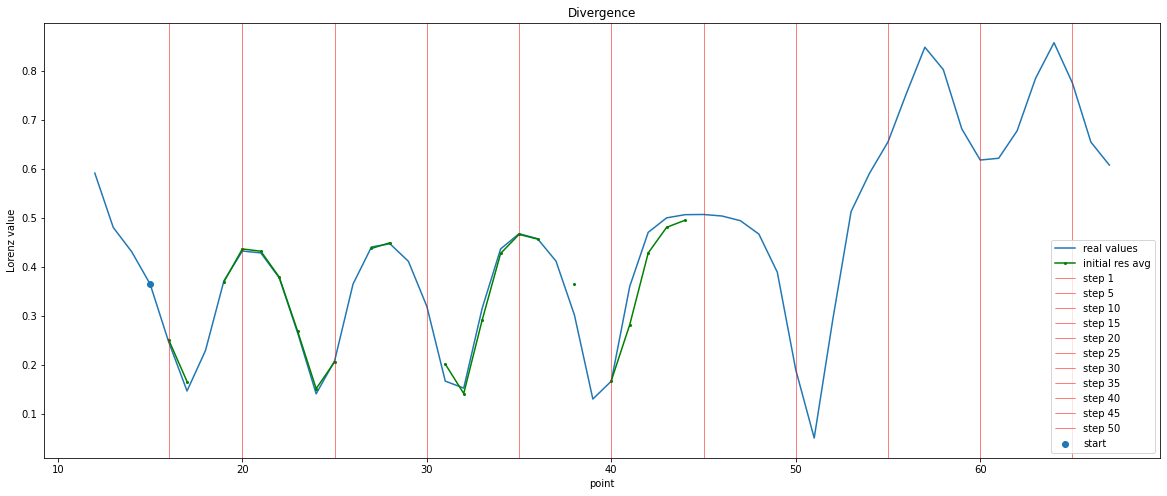

In [ ]:
visualize_point([(init_demon, 'initial res avg')], 
                15, 
                real_vals=x_test
                )

In [ ]:
Ideal_deamon_test = IdealDeamon(mode='dist', real_vals=x_test)

In [ ]:
generate_predictions(centers, deamon=Ideal_deamon_test, real_mode='test')

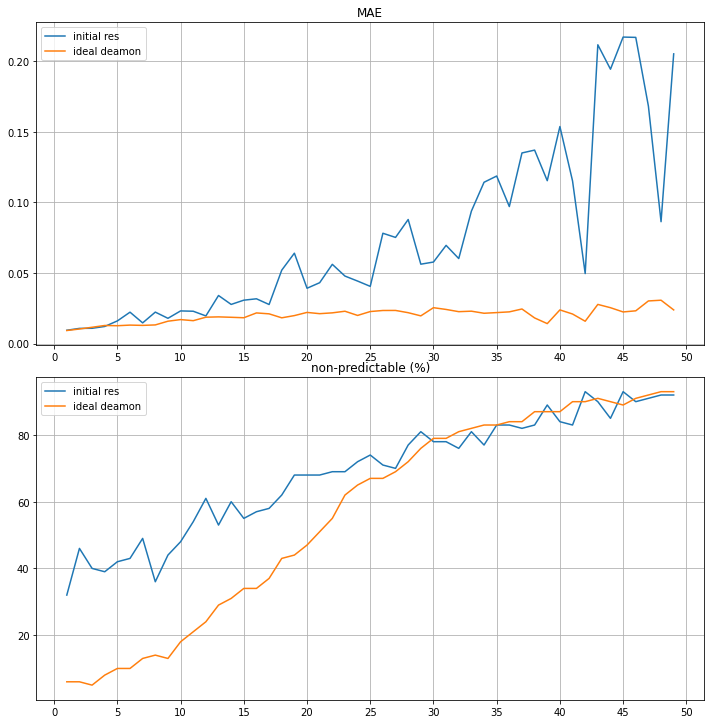

In [ ]:
deamons = [(init_demon, 'initial res'), (Ideal_deamon_test, 'ideal deamon')]
get_metrics(deamons, x_test)

# Self-healing подготовка

In [ ]:
WINDOW = 14

In [ ]:
def generate_patterns_for_self():
    self_patterns = generate_subsequences(WINDOW - 1, N - 1)
    return random.choices(self_patterns, k=100)

In [ ]:
self_patterns = generate_patterns_for_self()

In [ ]:
x_trains = {}

for pattern in self_patterns:
    key = str_subseq(pattern + (WINDOW - 1,))
    x_trains[key] = generate_sample(x_train, WINDOW, pattern, put_none=False)

In [ ]:
%%time

self_centers = generate_centers(x_trains)

CPU times: user 19min 33s, sys: 394 ms, total: 19min 34s
Wall time: 19min 38s


# Self-healing функции

### Переменные

In [102]:
WINDOW = 14

In [103]:
best_classifiers = [(LogisticRegression(C=1), 'logreg'),
                    (SVC(C=1, kernel='poly'), 'svm'),
                    (DecisionTreeClassifier(), 'decision tree'),
                    (KNeighborsClassifier(n_neighbors=3, weights='distance'), 'knn'),
                    (MLPClassifier(activation='logistic', hidden_layer_sizes=(128, 64, 32, 16)),
                      'mlp')]

In [104]:
best_classifiers_cb = [CatBoostClassifier(depth=15, iterations=17, learning_rate=1, random_seed=42)]

### Классы алгоритма Self-healing

#### "Простой" self-healing без определения непрогнозируемых точек  

In [105]:
class SelfDemonSimple(object):
    def __init__(self):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}

    @property
    def label(self):
        return self.stat.label()

    def predict(self, start_point, step, preds, val):
        self.set_predictions[start_point].append(preds)
        if not preds:
            pred = val
            self.predictions[start_point].append(pred)
            return pred
        
        pred, preds, weights = get_weights(start_point, step, 'dist', self.set_predictions)
        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

#### "Идеальный" self-healing, сравнивающий прогноз с истинным значением

In [106]:
class SelfDeamonIdeal(object):
    def __init__(self, eps=0.05, mode='simple', real_vals=x_test):
        self.eps = eps
        self.real_vals=real_vals
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        
    @property
    def label(self):
        return 'Ideal model of demon'

    def predict(self, start_point, step, preds, val):
        self.set_predictions[start_point].append(preds)
        pred, _, _ = get_weights(start_point, step, 'dist', self.set_predictions)

        if not pred or abs(pred - self.real_vals[start_point + step]) > self.eps:
            pred = val

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
       return self.predictions
    
    def get_set_predictions(self):
       return self.set_predictions

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

#### Self-healing, использующий МО для определения непрогнозируемых точек

In [107]:
class SelfDemon(object):
    def __init__(self, clf, stats, scaler, ensemble=False):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.clf = clf
        self.stats = stats
        self.scaler = scaler
        self.ensemble = ensemble
        
    @property
    def label(self):
        return self.stat.label()

    def predict(self, start_point, step, preds, val):
        self.set_predictions[start_point].append(preds)
        if not preds:
            pred = val
            self.predictions[start_point].append(pred)
            return pred
        
        pred, preds, weights = get_weights(start_point, step, 'dist', self.set_predictions)
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1)) 

        features = []
        for stat in self.stats:
            features.append(stat.apply(preds, hist_vals))
        
        features = self.scaler.transform([features])
        
        if self.ensemble:
            votes = self.clf.predict(features)

            if np.mean(votes) <= 0.5:
                pred = val
                self.predictions[start_point].append(pred)
                return pred
        else:
            if not self.clf.predict(features):
                pred = val
                self.predictions[start_point].append(pred)
                return pred

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    # def reset(self):
    #     self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
    #     self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}


    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

### Функции

#### Подстановка паттерна с позицией точки

In [108]:
def gen_sample_in_point_sf(values, window, pattern, pos, i): #change
    if i == N - 1 or pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = False

        if i != N - 1:
            bad = values[pos] == None

        for j in range(len(pattern)):
            val = values[pos - window + 1 + pattern[j]]
            if val == None and i != j:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        
        vals.append(values[pos])
        return vals
    else:
        return None

#### Функция предсказания 

In [109]:
from tqdm import trange, tqdm

def generate_predictions_sf(sf_centers, demon, self_demon, return_set_pred=False, all=False, extend=False, last_p=False, real_mode='test',
                          EPS=0.05, Q_VALUE=0.99):

    start_p_preds = {}
    start_p_set_preds = {}

    #mycomm: тестовая
    if real_mode == 'test':
        end_point = val_sf_end 
        init_point = test_init
    
    #mycomm: валидационная
    else:
        end_point = val_end 
        init_point = val_sf_init

    patterns_tmp = list(map(lambda x: tuple(list(map(lambda y: int(y), x.split(',')[:-1]))), list(sf_centers.keys())))  

    for start_point in tqdm(range(1, PTS)): 

        # initialize empty
        start_p_preds[start_point] = [None] * (start_point + 1) 
        if return_set_pred:
            start_p_set_preds[start_point] = [None] * (start_point + 1)

        
        data = demon.get_predictions()[start_point][start_point + 1:]
      
        # проходимся по ряду
        for step in range(1, STEPS + 1):
            possible_vals = []
            if extend:
                possible_vals = demon.get_set_predictions()[start_point][start_point + step]
            
            if data and (data[step - 1] is None) or (all and step > WINDOW):
                    
                # проходимся по позициям в паттерне 
                for i in range(N - 1):            
                    x_tests_for_point = {}
                    
                    # проходимя по паттернам  
                    for pattern in patterns_tmp:    
                        key = str_subseq(pattern + (WINDOW - 1,))
                        x_tests_for_point[key] = None

                        start_w = step - 1 - pattern[i]

                        if start_w >= 0:
                          wind = data[start_w : start_w + WINDOW]
                          sample = gen_sample_in_point_sf(wind, WINDOW, pattern, len(wind) - 1, i) 
                          
                          if sample:
                              x_tests_for_point[key] = sample

          
                    chosen_centers = []
                    for pattern, centers_values in sf_centers.items():

                        if not x_tests_for_point[pattern] is None:
                            vector = np.array(x_tests_for_point[pattern][:i] + x_tests_for_point[pattern][i + 1:])

                            for center in centers_values:
                                dist = euclidean(vector, np.hstack((center[:i], center[i + 1:])))
                                if dist < EPS:
                                    weight_d = (EPS - dist) / EPS
                                    chosen_centers.append((pattern, center, weight_d))


                            possible_vals += list(map(lambda center: (center[1][i], center[2], center[0]), 
                                                  chosen_centers)) #mycomm: (i-е значение, d, паттерн)

                if last_p:
                    for pattern in patterns_tmp:
                        key = str_subseq(pattern + (WINDOW - 1,)) 
                        start_w = step - WINDOW
                        # print(step, start_w)

                        if start_w >= 0:
                              wind = data[start_w : start_w + WINDOW]

                        # print(wind)
                        sample = gen_sample_in_point_sf(wind, WINDOW, pattern, len(wind) - 1, N-1)
                        
                        if not sample:
                            x_tests_for_point[key] = None
                        else:
                            x_tests_for_point[key] = sample
                            # print(sample[-1])

                    chosen_centers = []
                    for pattern, centers_values in sf_centers.items():

                        if not x_tests_for_point[pattern] is None:
                            vector = np.array(x_tests_for_point[pattern][:-1])

                            for center in centers_values:
                                dist = euclidean(vector, center[:-1])
                                if dist < EPS:
                                    weight_d = (EPS - dist) / EPS
                                    chosen_centers.append((pattern, center, weight_d))


                            possible_vals += list(map(lambda center: (center[1][-1], center[2], center[0]), 
                                                  chosen_centers)) #mycomm: (i-е значение, d, паттерн)
                                  


            result_point = self_demon.predict(start_point, step, possible_vals, data[step - 1])
            
            start_p_preds[start_point].append(result_point)

            if return_set_pred:
                start_p_set_preds[start_point].append(possible_vals)

    if return_set_pred:
        return start_p_preds, start_p_set_preds

    return start_p_preds

#### Применение и скачивание self-healing

In [110]:
def load_sf_ml(X, y, n, clf, stats, scaler, path, ex=False):
  sf = []

  clf.fit(X, y)

  for i in range(n):
      sf.append(SelfDemon(clf, lin_stats, lin_scaler))
      f_name_pred = path + '_pred' + str(i + 1)
      f_name_set = path + '_set' + str(i + 1)

      if ex:
        f_name_pred += '_ex'
        f_name_set += '_ex'

      f_name_pred += '.npy'
      f_name_set += '.npy'

      preds = np.load(f_name_pred, allow_pickle=True).item()
      #preds_set = np.load(f_name_set, allow_pickle=True).item()
      sf[i].set_preds(preds)
      #sf[i].set_preds_set(preds_set)
  return sf

In [111]:
def apply_sf_ml(X, y, n, clf, stats, scaler, init=init_demon, all=False, extend=False, eps=0.05, last_p=False, self_centers=self_centers):
  sf = []

  clf.fit(X, y)

  for i in range(n):
      sf.append(SelfDemon(clf, stats, scaler))

  generate_predictions_sf(self_centers, init, sf[0], all=all, extend=extend, last_p=True)

  for i in range(len(sf) - 1):
    generate_predictions_sf(self_centers, sf[i], sf[i + 1], all=all, extend=extend, EPS=eps, last_p=last_p)

  return sf

# Тестирование базовых алгоритмов

In [ ]:
sf_simple = SelfDemonSimple()

In [ ]:
generate_predictions_sf(self_centers, init_demon, sf_simple, all=False)

In [ ]:
sf_ideal = SelfDeamonIdeal()

In [ ]:
generate_predictions_sf(self_centers, init_demon, sf_ideal, all=False)

In [ ]:
sf_ideal2 = SelfDeamonIdeal()

In [ ]:
generate_predictions_sf(self_centers, sf_ideal, sf_ideal2, all=False)

In [ ]:
sf_ideal3 = SelfDeamonIdeal()

In [ ]:
generate_predictions_sf(self_centers, sf_ideal2, sf_ideal3, all=False)

In [ ]:
np.save('drive/My Drive/irka/ideal3.npy', sf_ideal3.get_predictions())

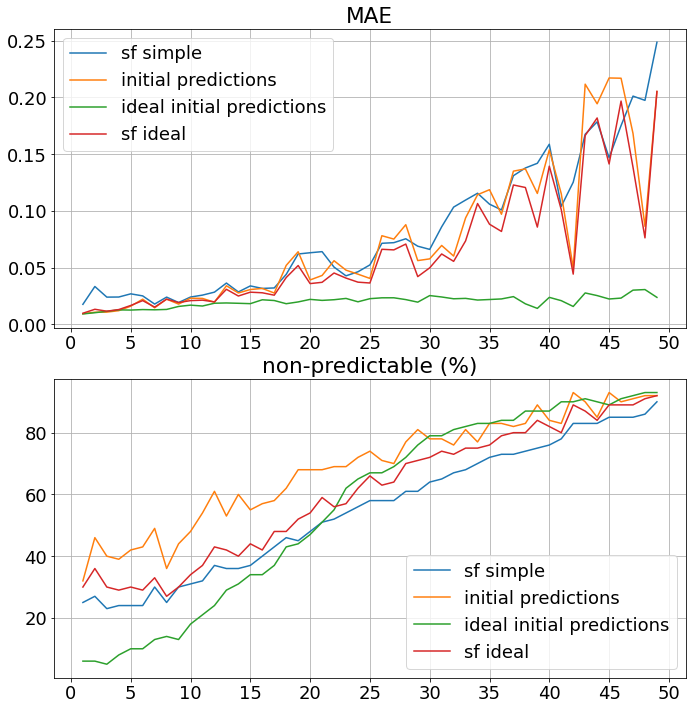

In [ ]:
deamons = [(sf_simple, 'sf simple'),
           (init_demon, "initial predictions"),
           (Ideal_deamon_test, 'ideal initial predictions'),
           (sf_ideal, 'sf ideal')
]
res = get_metrics(deamons, x_test)

# Обычное сравнение классификаторов

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.1)

In [ ]:
all_params = [
              {'C' : [1e-2, 1e-1, 1]},
              {'C' : [1e-2, 1e-1, 1, 10],
               'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']},
              {'criterion' : ['gini', 'entropy'],
               'max_depth': [None, 2, 4, 6, 8]},
              {'n_neighbors' : [3, 5, 7],
               'weights' : ['uniform', 'distance']},
              {'hidden_layer_sizes' : [(8,),(16,), (32,), (64, 32), 
                                       (64, 32, 16), (128, 64, 32, 16)],
               'activation' : ['logistic']}
]

classifiers = [
               (LogisticRegression(), 'logreg'),
               (SVC(), 'svm'),
               (DecisionTreeClassifier(), 'decision tree'),
               (KNeighborsClassifier(), 'knn'),
               (MLPClassifier(), 'mlp')
]

best_classifiers = []

for i, clf in enumerate(classifiers):
    
    if clf[1] == 'logreg':
        cur_clf = check_clf(clf, all_params[i], X_train_lin, X_test_lin, y_train_lin, y_test_lin)
    else:
        cur_clf = check_clf(clf, all_params[i], X_train, X_test, y_train, y_test)
    best_classifiers.append((cur_clf, clf[1]))
    print()

logreg
Accuracy:  0.6520423600605144
F1-score:  0.676056338028169
Best params:  {'C': 1}

svm
Accuracy:  0.6520423600605144
F1-score:  0.6714285714285715
Best params:  {'C': 1, 'kernel': 'poly'}

decision tree
Accuracy:  0.7246596066565809
F1-score:  0.7307692307692307
Best params:  {'criterion': 'gini', 'max_depth': None}

knn
Accuracy:  0.7912254160363086
F1-score:  0.8050847457627119
Best params:  {'n_neighbors': 3, 'weights': 'distance'}

mlp
Accuracy:  0.6580937972768532
F1-score:  0.6554878048780487
Best params:  {'activation': 'logistic', 'hidden_layer_sizes': (128, 64, 32, 16)}



In [ ]:
for clf in best_classifiers:
  if clf[1] == 'logreg':
    st = time.time()
    clf[0].fit(X_lin, y_lin)
    print(time.time() - st, clf[1])

  else:
    st = time.time()
    clf[0].fit(X, y)
    print(time.time() - st, clf[1])

0.03145098686218262 logreg
2.840667486190796 svm
0.046311140060424805 decision tree
0.0065114498138427734 knn
18.15364646911621 mlp


#### CatBoost

In [ ]:
all_params = [{'iterations' : [1, 5, 7, 10, 15, 17],
               'learning_rate' : [1, 0.8, 0.9, 0.8, 0.7, 0.5, 0.1],
                'depth' : [2, 4, 6, 8, 10, 15, 17],
                'random_seed' : [42]
               }
]

classifiers = [(CatBoostClassifier(), 'CatBoost')]

for i, clf in enumerate(classifiers):
    cur_clf = check_clf(clf, all_params[i], X_train, X_test, y_train, y_test)
    best_classifiers_cb = (cur_clf, clf[1])
    print()

CatBoost


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
420 fits failed out of a total of 2940.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 4923, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model, callbacks, log_cout, log_cerr)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 2184, in _fit
    callbacks=call

0:	learn: 0.5890397	total: 618ms	remaining: 9.89s
1:	learn: 0.5582813	total: 1.18s	remaining: 8.82s
2:	learn: 0.5339853	total: 1.73s	remaining: 8.09s
3:	learn: 0.5097555	total: 2.28s	remaining: 7.43s
4:	learn: 0.4961806	total: 2.85s	remaining: 6.84s
5:	learn: 0.4768800	total: 3.4s	remaining: 6.23s
6:	learn: 0.4585871	total: 3.96s	remaining: 5.66s
7:	learn: 0.4477691	total: 4.53s	remaining: 5.09s
8:	learn: 0.4383234	total: 5.09s	remaining: 4.52s
9:	learn: 0.4276050	total: 5.66s	remaining: 3.96s
10:	learn: 0.4107739	total: 6.21s	remaining: 3.39s
11:	learn: 0.4014002	total: 6.77s	remaining: 2.82s
12:	learn: 0.3930566	total: 7.33s	remaining: 2.25s
13:	learn: 0.3813757	total: 7.9s	remaining: 1.69s
14:	learn: 0.3719052	total: 8.46s	remaining: 1.13s
15:	learn: 0.3588061	total: 9.01s	remaining: 563ms
16:	learn: 0.3549247	total: 9.56s	remaining: 0us
Accuracy:  0.7397881996974282
F1-score:  0.7345679012345678
Best params:  {'depth': 15, 'iterations': 17, 'learning_rate': 1, 'random_seed': 42}



In [ ]:
import time

st = time.time()
best_classifiers_cb[0].fit(X, y)
time.time() - st

0:	learn: 0.5956771	total: 896ms	remaining: 14.3s
1:	learn: 0.5537287	total: 1.72s	remaining: 12.9s
2:	learn: 0.5233327	total: 2.53s	remaining: 11.8s
3:	learn: 0.5029898	total: 3.33s	remaining: 10.8s
4:	learn: 0.4913884	total: 3.98s	remaining: 9.55s
5:	learn: 0.4735582	total: 4.6s	remaining: 8.43s
6:	learn: 0.4592077	total: 5.24s	remaining: 7.48s
7:	learn: 0.4447045	total: 5.88s	remaining: 6.62s
8:	learn: 0.4346660	total: 6.52s	remaining: 5.79s
9:	learn: 0.4263053	total: 7.16s	remaining: 5.01s
10:	learn: 0.4091748	total: 7.79s	remaining: 4.25s
11:	learn: 0.3998784	total: 8.44s	remaining: 3.52s
12:	learn: 0.3917564	total: 9.29s	remaining: 2.86s
13:	learn: 0.3817604	total: 10.5s	remaining: 2.25s
14:	learn: 0.3678192	total: 11.3s	remaining: 1.51s
15:	learn: 0.3644308	total: 12.1s	remaining: 756ms
16:	learn: 0.3564151	total: 12.8s	remaining: 0us


12.966525793075562

#### AdaBoost

In [ ]:
classifiers = [
               (LogisticRegression(), 'logreg'),
               (SVC(), 'svm')
]


for clf in classifiers:
    if clf[1] == 'logreg':
        st = time.time()
        AdaBoostClassifier(base_estimator=clf[0], algorithm='SAMME').fit(X_train_lin, y_train_lin)
        print(time.time() - st)

        ab = AdaBoostClassifier(base_estimator=clf[0], algorithm='SAMME').fit(X_train_lin, y_train_lin)
        preds = ab.predict(X_test_lin)
        score = sklearn.metrics.accuracy_score(preds, y_test_lin)
        score2 = sklearn.metrics.f1_score(preds, y_test_lin)
        print(score, score2)

    else:
        st = time.time()
        AdaBoostClassifier(base_estimator=clf[0], algorithm='SAMME').fit(X, y)
        print(time.time() - st)
        
        ab = AdaBoostClassifier(base_estimator=clf[0], algorithm='SAMME').fit(X_train, y_train)
        preds = ab.predict(X_test)
        score = sklearn.metrics.accuracy_score(preds, y_test)
        score2 = sklearn.metrics.f1_score(preds, y_test)
        print(score, score2)

#### Stacking

In [ ]:
classifiers_1 = [
               ('logreg', best_classifiers[0][0]),
               ('svm', best_classifiers[1][0]),
               ('mlp', best_classifiers[4][0])
]

st = time.time()
clf = StackingClassifier(estimators=classifiers_1[1:]).fit(X, y)
print('time:', time.time() - st)

clf = StackingClassifier(estimators=classifiers_1[1:]).fit(X_train, y_train)
preds = clf.predict(X_test)
score = sklearn.metrics.accuracy_score(preds, y_test)
score2 = sklearn.metrics.f1_score(preds, y_test)
print(score, score2)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


time: 135.4075095653534
0.6777609682299546 0.6944045911047345


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# Сравнение self-healing с разными классификаторами

## Применение self-healing

#### svm [lp]

In [ ]:
sf_svm_lp = apply_sf_ml(X, y, 3, best_classifiers[1][0], all_stats, scaler, all=False, extend=False, last_p=True, eps=0.03)

100%|██████████| 99/99 [03:43<00:00,  2.26s/it]


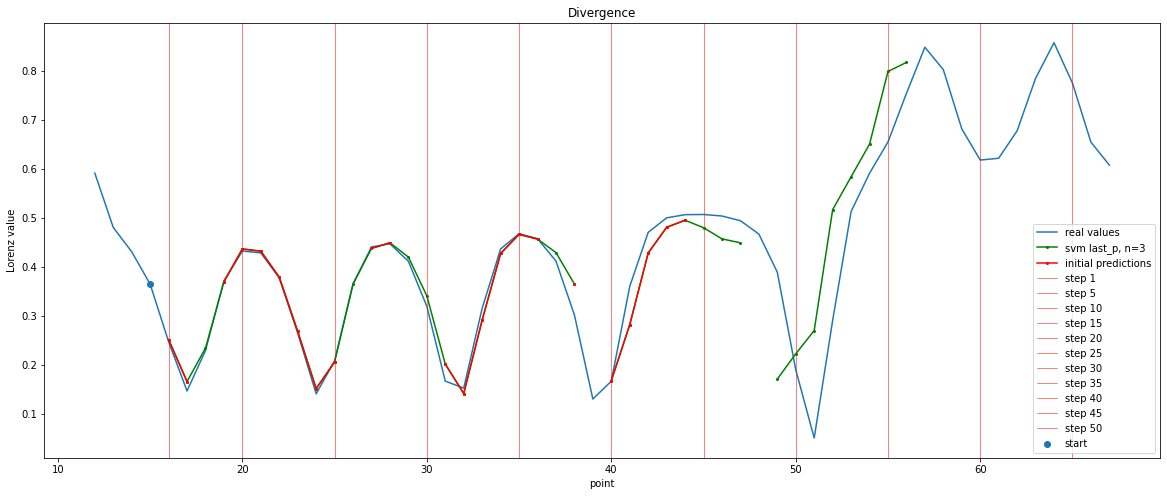

In [ ]:
visualize_point([(sf_svm_lp[2], 'svm last_p, n=3'), (init_demon, 'initial predictions')], 
                15, 
                real_vals=x_test
                )

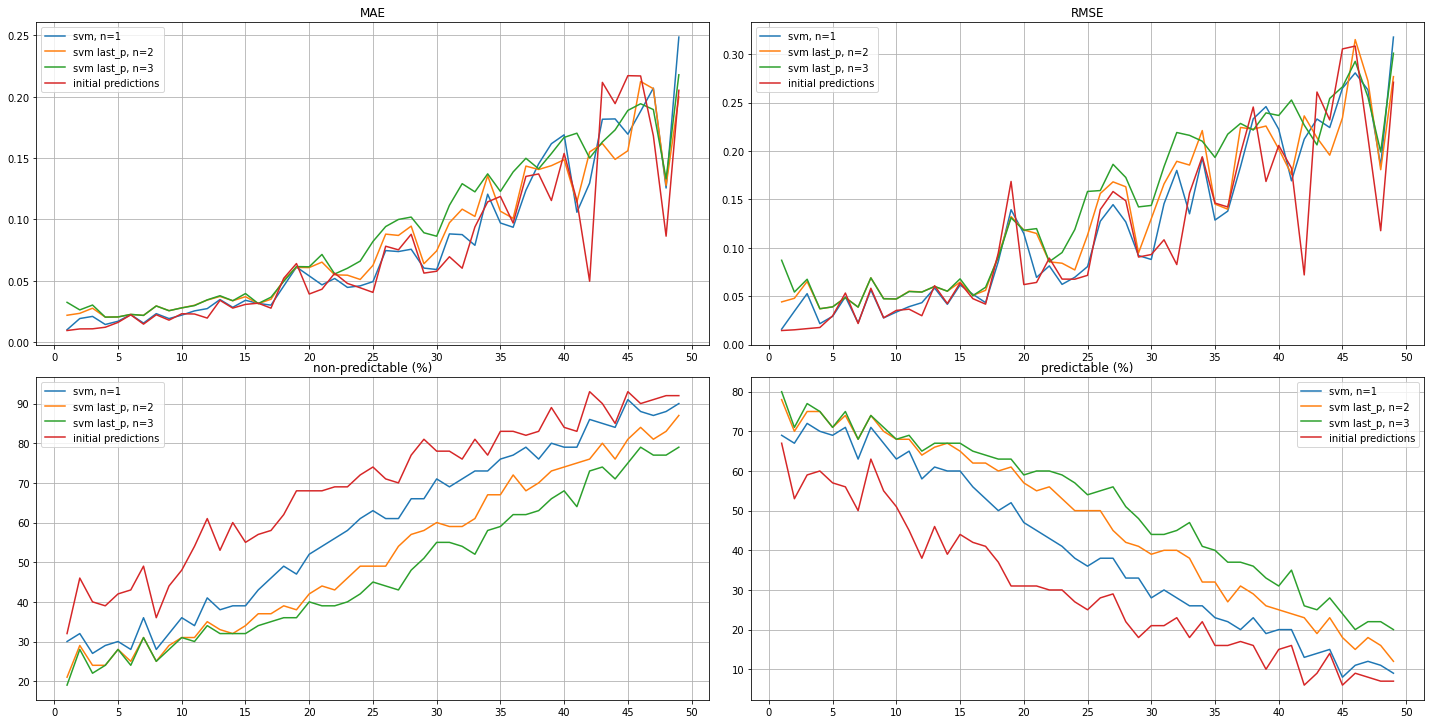

In [ ]:
deamons = [(sf_svm_lp[0], 'svm, n=1'),  
           (sf_svm_lp[1], 'svm last_p, n=2'),
           (sf_svm_lp[2], 'svm last_p, n=3'),
           (init_demon, "initial predictions")
]
get_metrics(deamons, x_test)

#### decision tree [lp]

In [ ]:
sf_dt_lp = apply_sf_ml(X, y, 4, best_classifiers[2][0], all_stats, scaler, all=False, extend=False, last_p=True, eps=0.03)

100%|██████████| 99/99 [07:28<00:00,  4.53s/it]


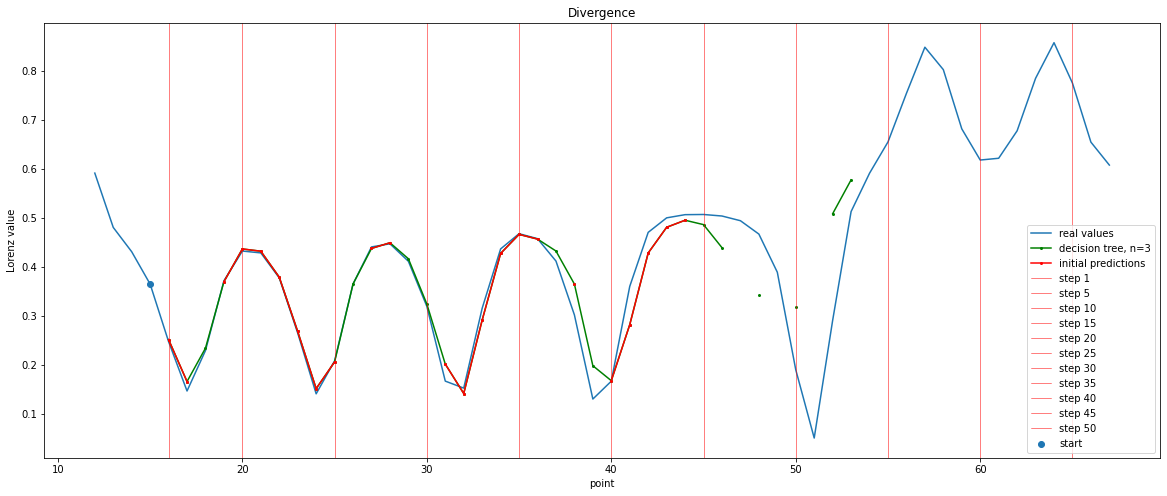

In [ ]:
visualize_point([(sf_dt_lp[2], 'decision tree, n=3'), (init_demon, 'initial predictions')], 
                15, 
                real_vals=x_test
                )

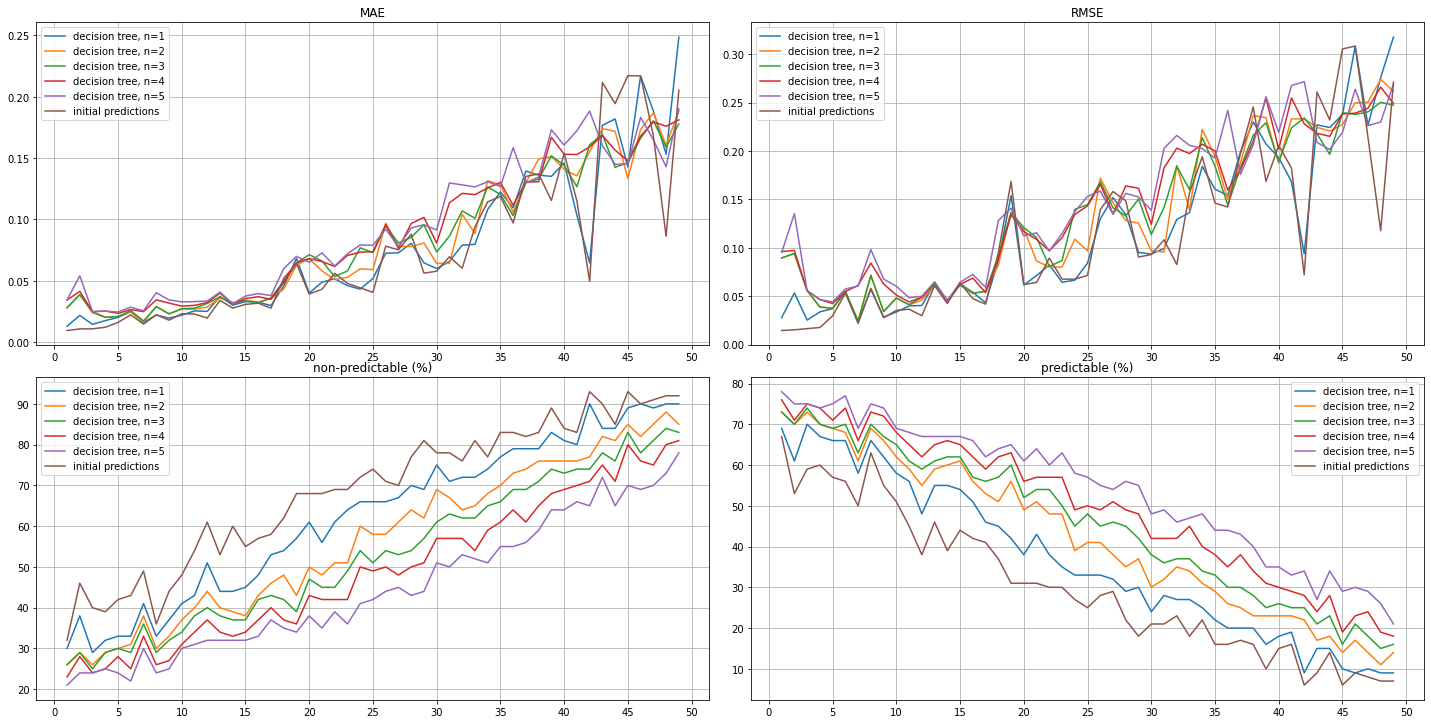

In [ ]:
deamons = [(sf_dt_lp[0], 'decision tree, n=1'),  
           (sf_dt_lp[1], 'decision tree, n=2'),
           (sf_dt_lp[2], 'decision tree, n=3'),
           (sf_dt_lp[3], 'decision tree, n=4'),
           (sf_dt_lp[4], 'decision tree, n=5'),

           (init_demon, "initial predictions")
]
dt_metrics = get_metrics(deamons, x_test, True)

#### кнн [lp]

In [ ]:
sf_knn_lp = apply_sf_ml(X, y, 4, best_classifiers[3][0], all_stats, scaler, all=False, extend=False, last_p=True, eps=0.05)

100%|██████████| 99/99 [14:09<00:00,  8.58s/it]


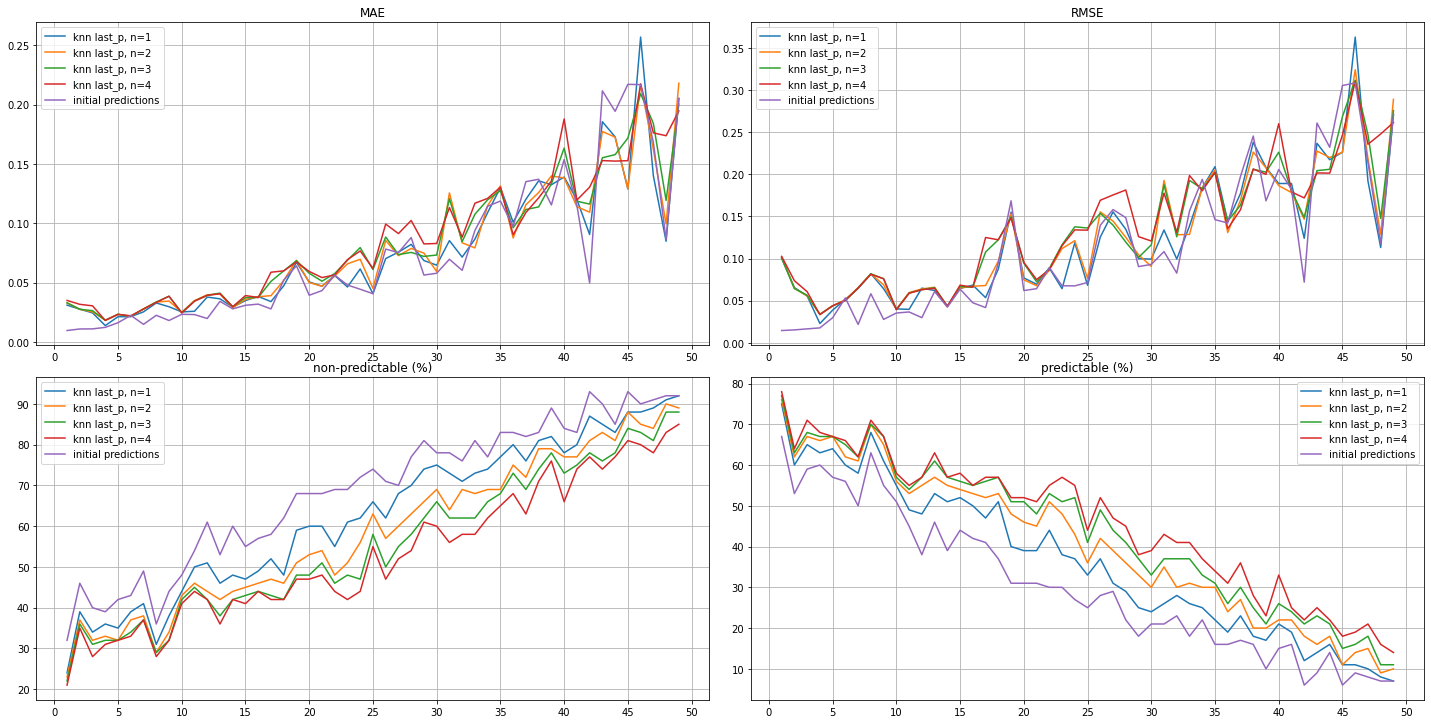

In [ ]:
deamons = [(sf_knn_lp[0], 'knn last_p, n=1'),  
           (sf_knn_lp[1], 'knn last_p, n=2'),
           (sf_knn_lp[2], 'knn last_p, n=3'),
           (sf_knn_lp[3], 'knn last_p, n=4'),
           (init_demon, "initial predictions")
]
dt_metrics = get_metrics(deamons, x_test, True)

#### mlp [lp]

In [ ]:
sf_mlp_lp = apply_sf_ml(X, y, 4, best_classifiers[4][0], all_stats, scaler, all=False, extend=False, last_p=True, eps=0.05)

100%|██████████| 99/99 [14:10<00:00,  8.59s/it]


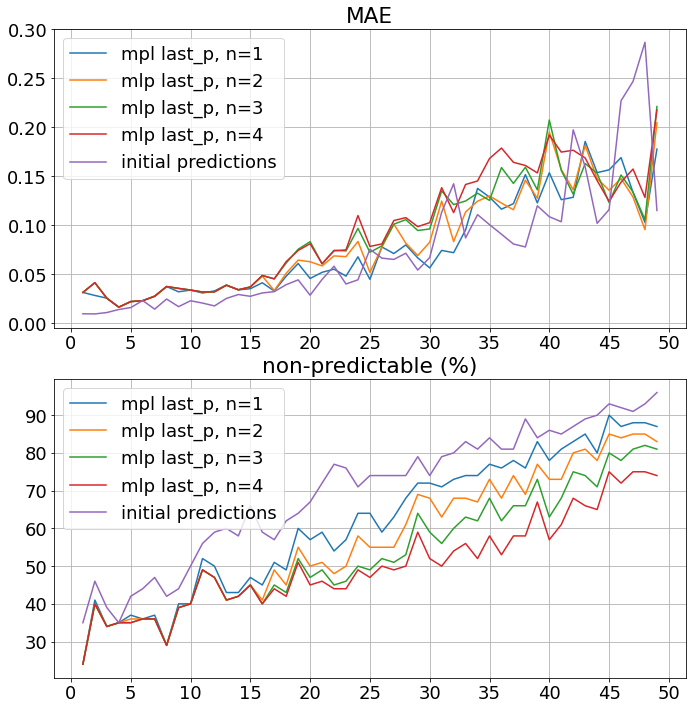

In [ ]:
deamons = [(sf_mlp_lp[0], 'mpl last_p, n=1'),  
           (sf_mlp_lp[1], 'mlp last_p, n=2'),
           (sf_mlp_lp[2], 'mlp last_p, n=3'),
           (sf_mlp_lp[3], 'mlp last_p, n=4'),
           (init_demon, "initial predictions")
]
dt_metrics = get_metrics(deamons, x_test, True)

### 

#### AdaBoost

In [ ]:
ada_boost_clf_lin = AdaBoostClassifier(base_estimator=LogisticRegression(), algorithm='SAMME')
sf_ada_boost_lin = apply_sf_ml(X_lin, y_lin, 3, ada_boost_clf_lin, lin_stats, lin_scaler, last_p=True)

100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


In [ ]:
ada_boost_clf_svm = AdaBoostClassifier(base_estimator=SVC(), algorithm='SAMME')
sf_ada_boost_svm = apply_sf_ml(X, y, 3, ada_boost_clf_svm, all_stats, scaler, last_p=True)

100%|██████████| 99/99 [13:28<00:00,  8.16s/it]


In [ ]:
np.save('drive/My Drive/irka/ada/logreg3.npy', sf_ada_boost_lin[-1].get_predictions())
np.save('drive/My Drive/irka/ada/svm3.npy', sf_ada_boost_svm[-1].get_predictions())

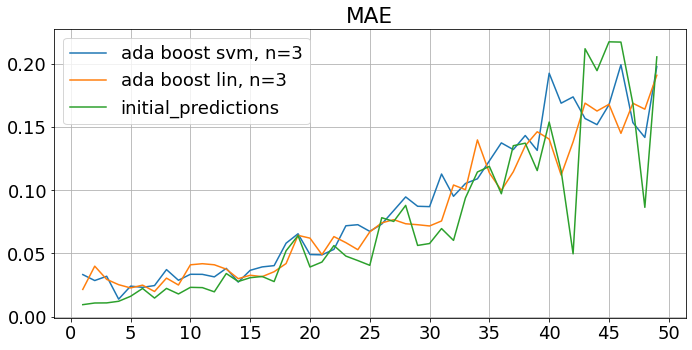

In [ ]:
get_metrics([(sf_ada_boost_svm[-1], 'ada boost svm, n=3'),
             (sf_ada_boost_lin[-1], 'ada boost lin, n=3'),
             (init_demon, 'initial_predictions')
            ], x_test)

#### Stacking

In [ ]:
classifiers_1 = [
               ('svm', best_classifiers[1][0]),
               ('mlp', best_classifiers[4][0])
]

stacking_clf = StackingClassifier(estimators=classifiers_1)
sf_stacking = apply_sf_ml(X, y, 3, stacking_clf, all_stats, scaler, last_p=True)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
100%|██████████| 99/99 [13:02<00:00,  7.91s/it]


In [ ]:
np.save('drive/My Drive/irka/ada/stacking3.npy', sf_stacking[-1].get_predictions())

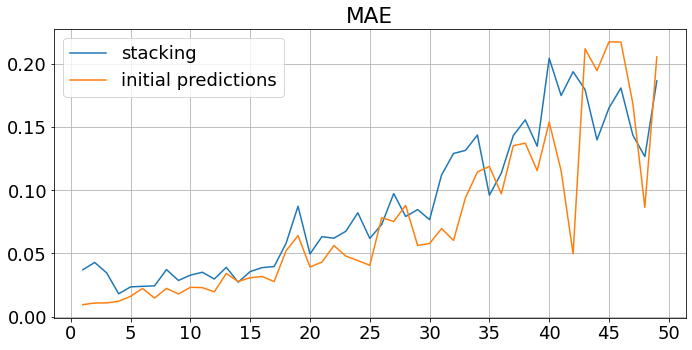

In [ ]:
get_metrics([(sf_stacking[-1], 'stacking'),
             (init_demon, 'initial predictions'), 
], x_test)

#### CatBoost

In [ ]:
sf_cb_lp = apply_sf_ml(X, y, 2, best_classifiers_cb[0], all_stats, scaler, init=sf_cb_lp[0][0], last_p=True)

0:	learn: 0.5824835	total: 863ms	remaining: 13.8s
1:	learn: 0.5539178	total: 1.59s	remaining: 12s
2:	learn: 0.5290271	total: 2.18s	remaining: 10.2s
3:	learn: 0.5137749	total: 2.8s	remaining: 9.1s
4:	learn: 0.4954759	total: 3.41s	remaining: 8.19s
5:	learn: 0.4811734	total: 4.02s	remaining: 7.38s
6:	learn: 0.4693646	total: 4.63s	remaining: 6.62s
7:	learn: 0.4554907	total: 5.24s	remaining: 5.89s
8:	learn: 0.4429441	total: 5.86s	remaining: 5.21s
9:	learn: 0.4271984	total: 6.47s	remaining: 4.53s
10:	learn: 0.4190202	total: 7.1s	remaining: 3.87s
11:	learn: 0.4063706	total: 7.71s	remaining: 3.21s
12:	learn: 0.3981132	total: 8.32s	remaining: 2.56s
13:	learn: 0.3838036	total: 8.94s	remaining: 1.91s
14:	learn: 0.3795353	total: 9.54s	remaining: 1.27s
15:	learn: 0.3716386	total: 10.1s	remaining: 630ms
16:	learn: 0.3600883	total: 10.6s	remaining: 0us


100%|██████████| 99/99 [14:05<00:00,  8.54s/it]


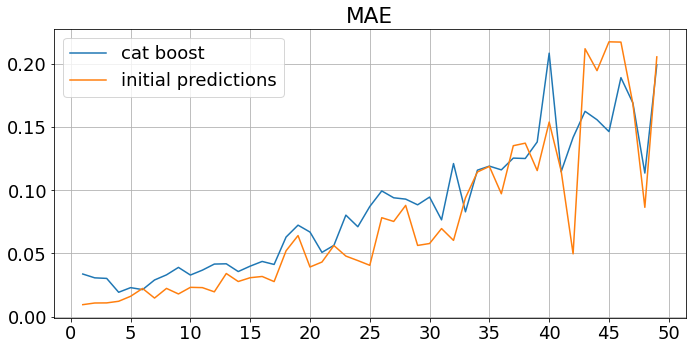

In [ ]:
get_metrics([(sf_cb_lp[-1], 'cat boost'), 
             (init_demon, 'initial predictions')             
], x_test)

In [ ]:
np.save('drive/My Drive/irka/ada/catboost3.npy', sf_cb_lp[-1].get_predictions())

#### FT-Transformer

In [ ]:
# Requirements:
!pip install rtdl
!pip install libzero==0.0.4

In [ ]:
from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

In [ ]:
device = torch.device('cpu')
# Docs: https://yura52.github.io/zero/0.0.4/reference/api/zero.improve_reproducibility.html
zero.improve_reproducibility(seed=123456)

123456

##### Data

In [ ]:
task_type = 'binclass'

In [ ]:
X_s = {}
y_s = {}
X_s['train'] = X
y_s['train'] = y

X_s = {k: torch.tensor(v.astype('float32'), device=device) for k, v in X_s.items()}
y_s = {k: torch.tensor(v.astype('int64'), device=device) for k, v in y_s.items()}


y_s = {k: v.float() for k, v in y_s.items()}

##### Model

In [ ]:
n_classes= 1
d_out = n_classes or 1

# model = rtdl.MLP.make_baseline(
#     d_in=X_all.shape[1],
#     d_layers=[128, 256, 128],
#     dropout=0.1,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

# model = rtdl.ResNet.make_baseline(
#     d_in=X_all.shape[1],
#     d_main=128,
#     d_intermidiate=256,
#     dropout_first=0.2,
#     dropout_second=0.0,
#     n_blocks=2,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

model = rtdl.FTTransformer.make_default(
    n_num_features=X.shape[1],
    cat_cardinalities=None,
    last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
    d_out=d_out,
)

# === ABOUT CATEGORICAL FEATURES ===
# IF you use MLP, ResNet or any other simple feed-forward model (NOT transformer-based model)
# AND there are categorical features
# THEN you have to implement a wrapper that handles categorical features.
# The example below demonstrates how it can be achieved using rtdl.CategoricalFeatureTokenizer.
# ==================================
# 1. When you have both numerical and categorical features, you should prepare you data like this:
#    (X_num<float32>, X_cat<int64>) instead of X<float32>
#    Each column in X_cat should contain values within the range from 0 to <(the number of unique values in column) - 1>;
#    use sklean.preprocessing.OrdinalEncoder to achieve this;
# 2. Prepare a list of so called "cardinalities":
#    cardinalities[i] = <the number of unique values of the i-th categorical feature>
# 3. See the commented example below and adapt it for your needs.
#
# class Model(nn.Module):
#     def __init__(
#         self,
#         n_num_features: int,
#         cat_tokenizer: rtdl.CategoricalFeatureTokenizer,
#         mlp_kwargs: Dict[str, Any],
#     ):
#         super().__init__()
#         self.cat_tokenizer = cat_tokenizer
#         self.model = rtdl.MLP.make_baseline(
#             d_in=n_num_features + cat_tokenizer.n_tokens * cat_tokenizer.d_token,
#             **mlp_kwargs,
#         )
#
#     def forward(self, x_num, x_cat):
#         return self.model(
#             torch.cat([x_num, self.cat_tokenizer(x_cat).flatten(1, -1)], dim=1)
#         )
#
# model = Model(
#     # `None` means "Do not transform numerical features"
#     # `d_token` is the size of embedding for ONE categorical feature
#     X_num_all.shape[1],
#     rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
#     mlp_kwargs,
# )
# Then the model should be used as `model(x_num, x_cat)` instead of of `model(x)`.

model.to(device)
optimizer = (
    model.make_default_optimizer()
    if isinstance(model, rtdl.FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
)
loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)

##### Training

In [ ]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


batch_size = 256
train_loader = zero.data.IndexLoader(len(X_s['train']), batch_size, device=device)

In [ ]:
n_epochs = 50
for epoch in range(1, n_epochs + 1):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X_s['train'][batch_idx]
        y_batch = y_s['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

##### Селф-филлинг с сетью

In [ ]:
class SelfDemonNet(object):
    def __init__(self, stats, scaler):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        # self.clf = clf
        self.stats = stats
        self.scaler = scaler

    @property
    def label(self):
        return self.stat.label()

    def predict(self, start_point, step, preds, val):
        self.set_predictions[start_point].append(preds)
        if not preds:
            pred = val
            self.predictions[start_point].append(pred)
            return pred
        
        pred, preds, weights = get_weights(start_point, step, 'dist', self.set_predictions)
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1)) 

        features = []
        for stat in self.stats:
            features.append(stat.apply(preds, hist_vals))
        
        features = self.scaler.transform([features])
        f = torch.tensor(features[0].astype('float32'), device=device)

        model.eval()
        prediction = []
        prediction.append(apply_model(f))
        prediction = torch.cat(prediction).squeeze(1).cpu().detach().numpy()
        point_is_np = np.round(scipy.special.expit(prediction))
        
        if int(point_is_np) == 0:
            pred = val
            self.predictions[start_point].append(pred)
            return pred

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    def reset(self):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}


    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

In [ ]:
sf_tr1 = SelfDemonNet(all_stats, scaler)
sf_tr2 = SelfDemonNet(all_stats, scaler)
sf_tr = SelfDemonNet(all_stats, scaler)

In [ ]:
generate_predictions_sf(self_centers, init_demon, sf_tr1, all=False)

In [ ]:
generate_predictions_sf(self_centers, sf_tr1, sf_tr2, all=False)

In [ ]:
generate_predictions_sf(self_centers, sf_tr2, sf_tr, all=False)

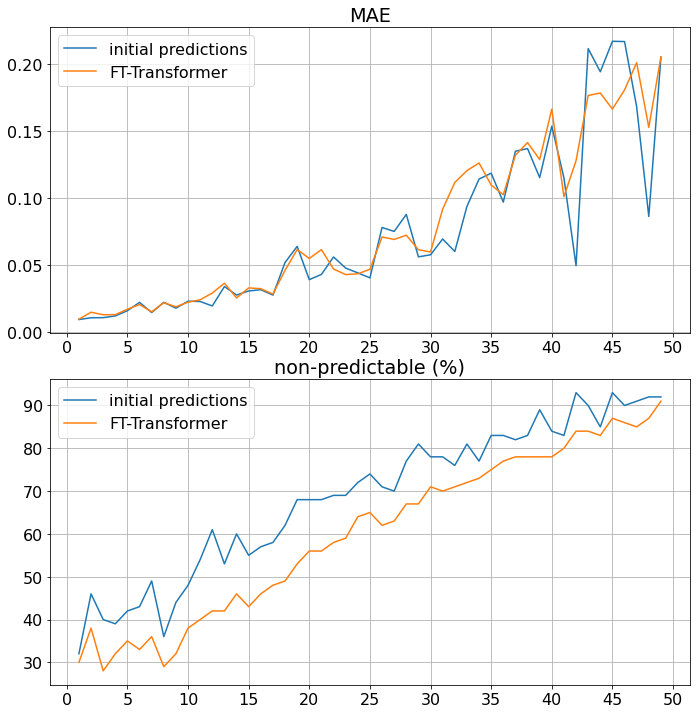

In [ ]:
deamons = [(init_demon, 'initial predictions'),
            (sf_tr, 'FT-Transformer')
]
get_metrics(deamons, x_test)

## Скачивание результатов

In [113]:
sf_lin_lp = load_sf_ml(X_lin, y_lin, 7, best_classifiers[0][0], lin_stats, lin_scaler, 'data/lin_lp/logreg_lp')

In [ ]:
sf_svm_lp = load_sf_ml(X, y, 3, best_classifiers[1][0], all_stats, scaler, 'data/svm_lp/svm_lp')

In [ ]:
sf_dt_lp = load_sf_ml(X, y, 5, best_classifiers[2][0], all_stats, scaler, 'data/dt_lp/dt_lp')

In [ ]:
sf_knn_lp = load_sf_ml(X, y, 4, best_classifiers[3][0], all_stats, scaler, 'data/knn_lp/knn_lp')

In [ ]:
sf_mlp_lp = load_sf_ml(X, y, 4, best_classifiers[4][0], all_stats, scaler, 'data/mlp_lp/mlp_lp')

In [ ]:
sf_ada_boost_lin = []
ml_demon = SelfDemon(clf=LogisticRegression(), stats=lin_stats, scaler=lin_scaler)
preds = np.load('data/ens/logreg3.npy', allow_pickle=True).item()
ml_demon.set_preds(preds)
sf_ada_boost_lin.append(ml_demon)

In [ ]:
sf_ada_boost_svm = []
ml_demon = SelfDemon(clf=SVC(), stats=all_stats, scaler=scaler)
preds = np.load('data/ens/svm3.npy', allow_pickle=True).item()
ml_demon.set_preds(preds)
sf_ada_boost_svm.append(ml_demon)

In [ ]:
classifiers_1 = [
               ('svm', best_classifiers[1][0]),
               ('mlp', best_classifiers[4][0])
]

clf = StackingClassifier(estimators=classifiers_1)
ml_demon = SelfDemon(clf=clf, stats=all_stats, scaler=scaler)
preds = np.load('data/ens/stacking3.npy', allow_pickle=True).item()
ml_demon.set_preds(preds)
sf_stacking = []
sf_stacking.append(ml_demon)

In [ ]:
ml_demon = SelfDemon(clf=best_classifiers_cb[0], stats=all_stats, scaler=scaler)
preds = np.load('data/ens/catboost3.npy', allow_pickle=True).item()
ml_demon.set_preds(preds)
sf_cb_lp = []
sf_cb_lp.append(ml_demon)

In [ ]:
sf_tr = SelfDemonNet(all_stats, scaler)
preds = np.load('data/tr/transformer3.npy', allow_pickle=True).item()
sf_tr.set_preds(preds)

## Сравнение методов

#### Все методы

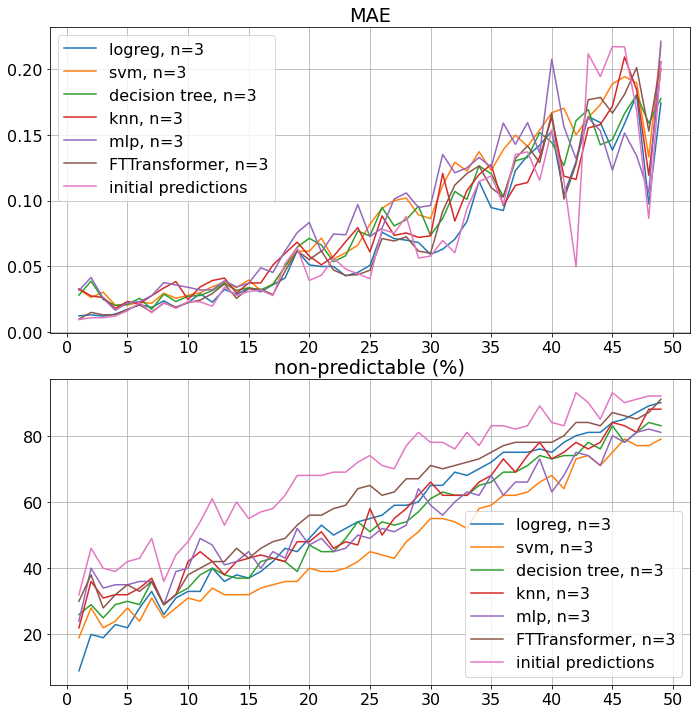

In [ ]:
deamons = [(sf_lin_lp[2], 'logreg, n=3'),  
           (sf_svm_lp[2], 'svm, n=3'),
           (sf_dt_lp[2], 'decision tree, n=3'),
           (sf_knn_lp[2], 'knn, n=3'),
           (sf_mlp_lp[2], 'mlp, n=3'),
           (sf_tr, 'FTTransformer, n=3'),
           (init_demon, "initial predictions")
]

plt.rcParams.update({'font.size': 16})
get_metrics(deamons, x_test)

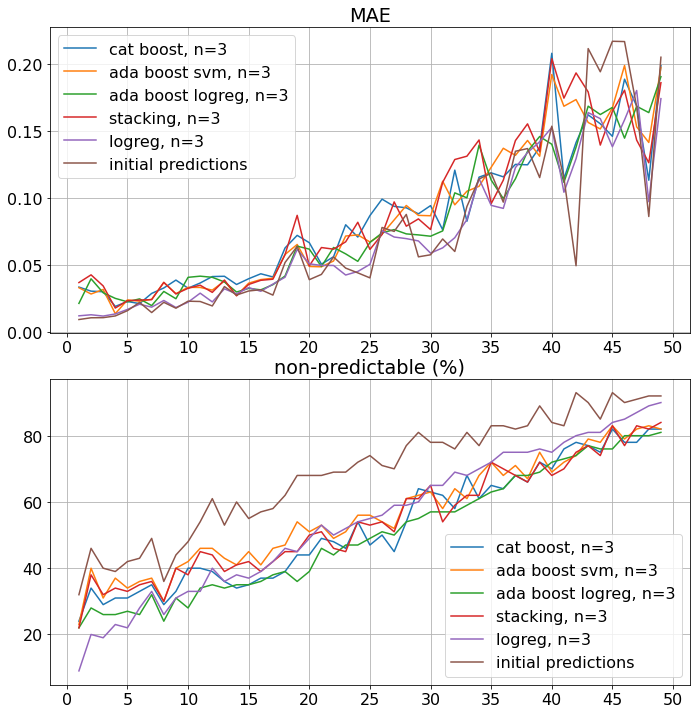

In [ ]:
plt.rcParams.update({'font.size': 16})

get_metrics([(sf_cb_lp[-1], 'cat boost, n=3'),
             (sf_ada_boost_svm[-1], 'ada boost svm, n=3'),
             (sf_ada_boost_lin[-1], 'ada boost logreg, n=3'),                 
             (sf_stacking[-1], 'stacking, n=3'),
             (sf_lin_lp[2], 'logreg, n=3'),     
             (init_demon, 'initial predictions'), 
             
], x_test)

#### попарное

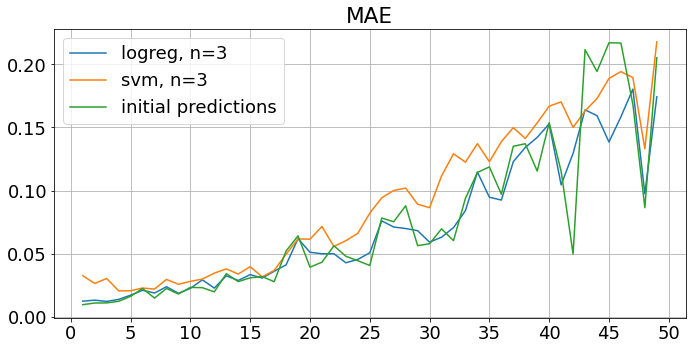

In [ ]:
plt.rcParams.update({'font.size': 16})

get_metrics([(sf_lin_lp[2], 'logreg, n=3'),  
              (sf_svm_lp[2], 'svm, n=3'),
              (init_demon, "initial predictions")
             
], x_test)

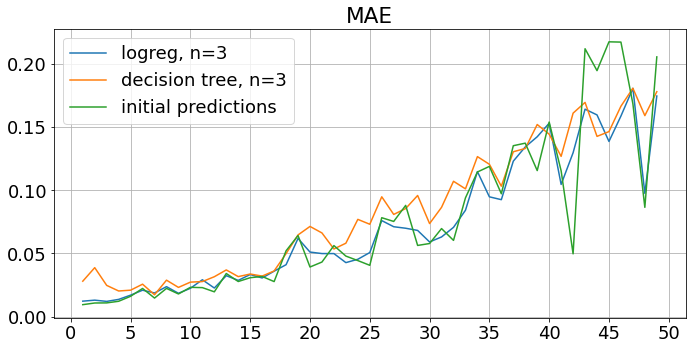

In [ ]:
plt.rcParams.update({'font.size': 16})

get_metrics([(sf_lin_lp[2], 'logreg, n=3'),  
              (sf_dt_lp[2], 'decision tree, n=3'),
              (init_demon, "initial predictions")
             
], x_test)

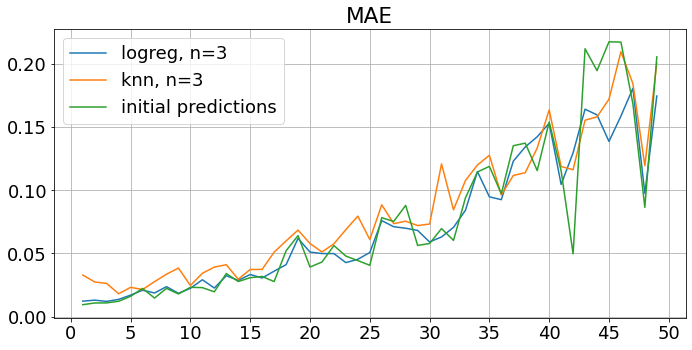

In [ ]:
plt.rcParams.update({'font.size': 16})

get_metrics([(sf_lin_lp[2], 'logreg, n=3'),  
              (sf_knn_lp[2], 'knn, n=3'),
              (init_demon, "initial predictions")
             
], x_test)

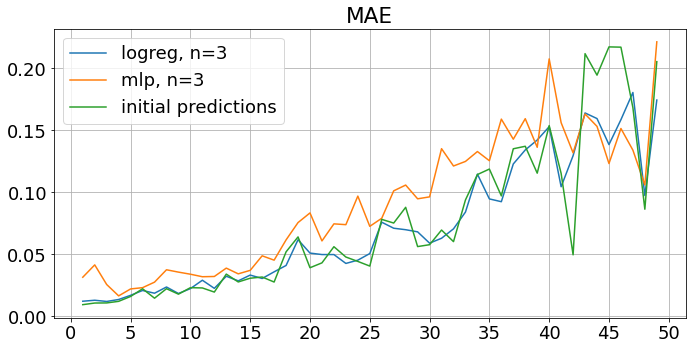

In [ ]:
plt.rcParams.update({'font.size': 16})

get_metrics([(sf_lin_lp[2], 'logreg, n=3'), 
              (sf_mlp_lp[2], 'mlp, n=3'),
              (init_demon, "initial predictions")
             
], x_test)

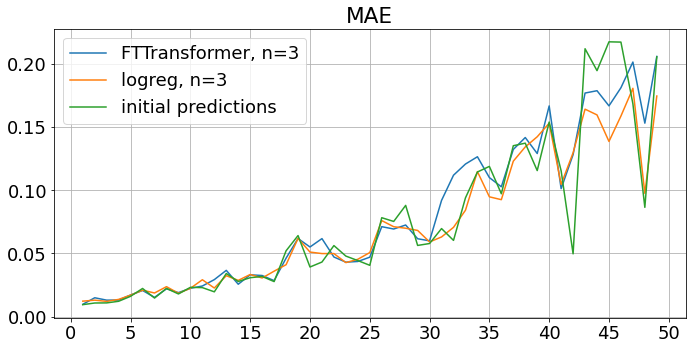

In [ ]:
plt.rcParams.update({'font.size': 16})

get_metrics([(sf_tr, 'FTTransformer, n=3'),  
              (sf_lin_lp[2], 'logreg, n=3'),
              (init_demon, "initial predictions")
             
], x_test)

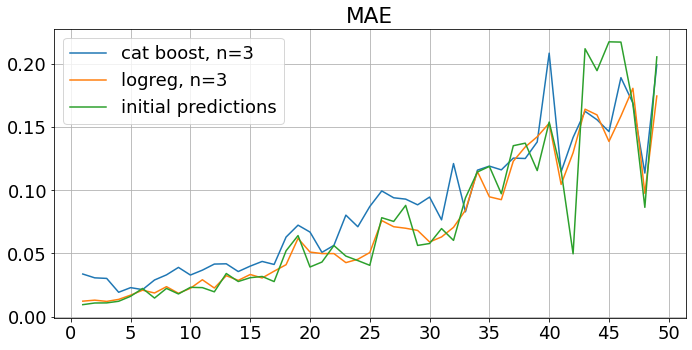

In [ ]:
plt.rcParams.update({'font.size': 16})

get_metrics([(sf_cb_lp[-1], 'cat boost, n=3'),
             (sf_lin_lp[2], 'logreg, n=3'),     
             (init_demon, 'initial predictions'), 
             
], x_test)

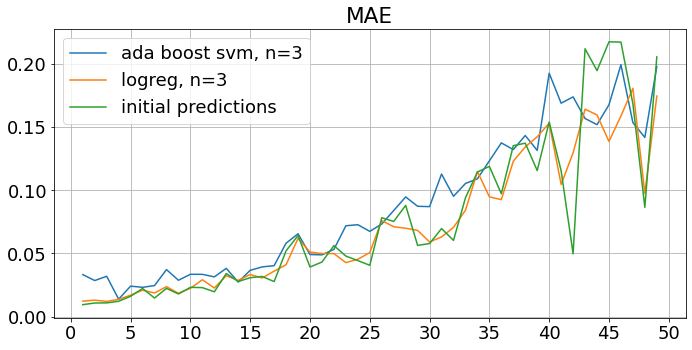

In [ ]:
plt.rcParams.update({'font.size': 16})

get_metrics([(sf_ada_boost_svm[-1], 'ada boost svm, n=3'),
             (sf_lin_lp[2], 'logreg, n=3'),     
             (init_demon, 'initial predictions'), 
             
], x_test)

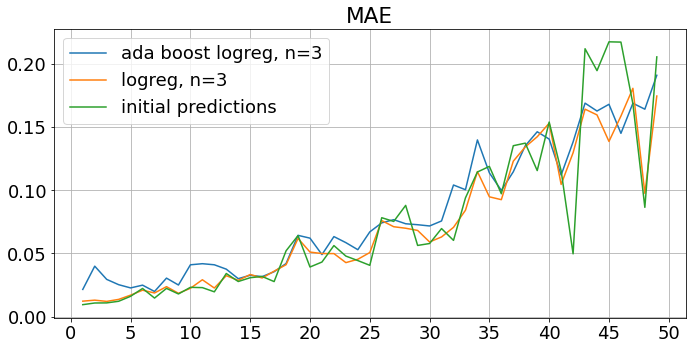

In [ ]:
plt.rcParams.update({'font.size': 16})

get_metrics([(sf_ada_boost_lin[-1], 'ada boost logreg, n=3'),                 
             (sf_lin_lp[2], 'logreg, n=3'),     
             (init_demon, 'initial predictions'), 
             
], x_test)

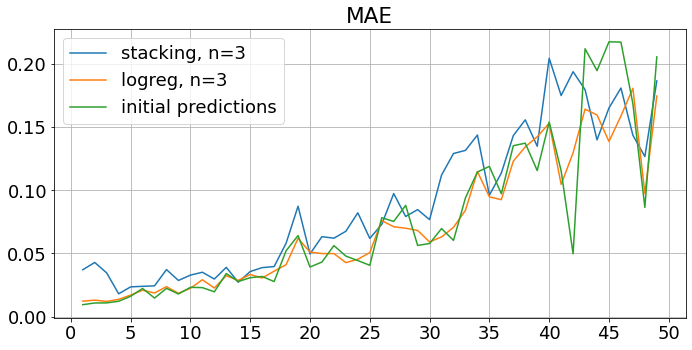

In [ ]:
plt.rcParams.update({'font.size': 16})

get_metrics([(sf_stacking[-1], 'stacking, n=3'),
             (sf_lin_lp[2], 'logreg, n=3'),     
             (init_demon, 'initial predictions'), 
             
], x_test)

#### разное

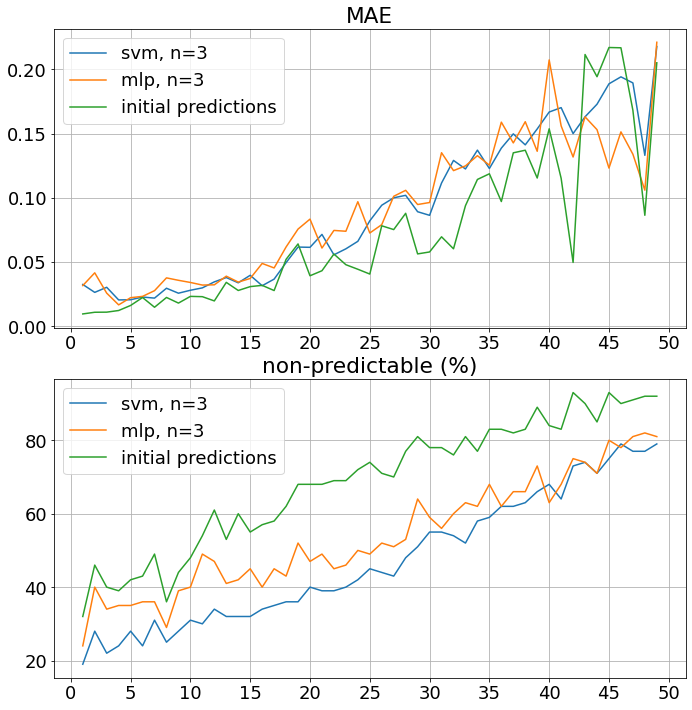

In [ ]:
deamons = [#(sf_lin_lp[2], 'logreg, n=3'),  
           (sf_svm_lp[2], 'svm, n=3'),
           #(sf_dt_lp[2], 'decision tree, n=3'),
           #(sf_knn_lp[2], 'knn, n=3'),
           (sf_mlp_lp[2], 'mlp, n=3'),
           #(sf_net4, 'FTTransformer, n=3'),
           #(sf_ideal, 'ideal'),
           (init_demon, "initial predictions")
]

plt.rcParams.update({'font.size': 18})
get_metrics(deamons, x_test)

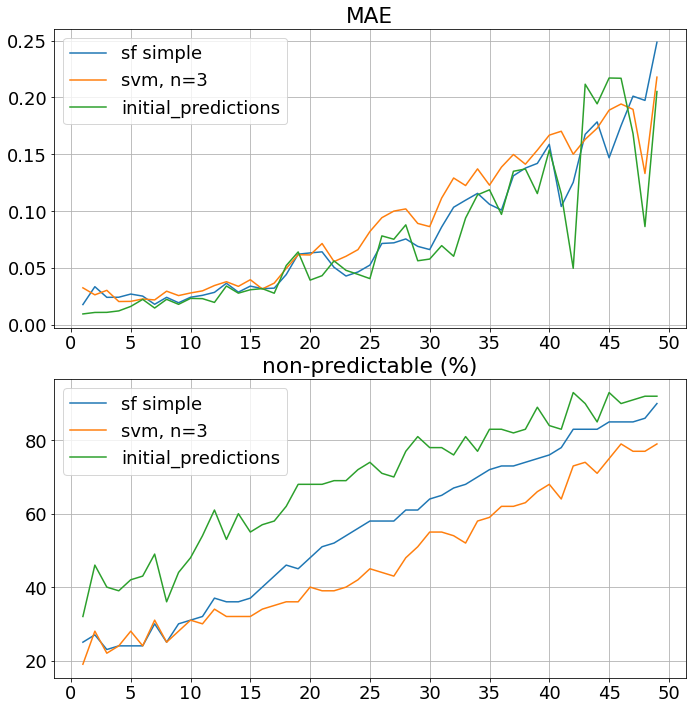

In [ ]:
plt.rcParams.update({'font.size': 18})

get_metrics([
             (sf_simple, 'sf simple'),
             (sf_svm_lp[2], 'svm, n=3'),
             (init_demon, 'initial_predictions')

            ], x_test)

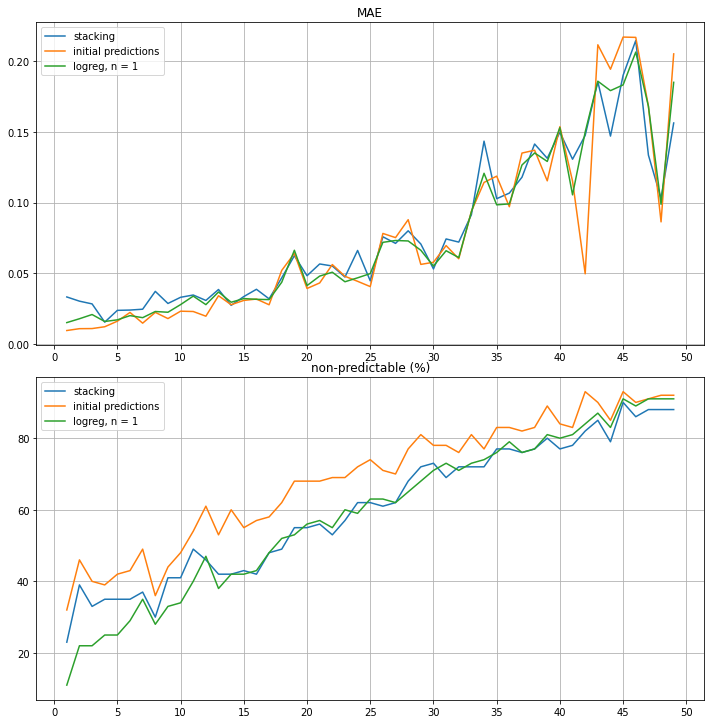

In [ ]:
get_metrics([stacking_demon, 
             (sf_lin_lp[0], 'logreg, n = 1'),
             (init_demon, 'initial predictions'),
             
], x_test)

# Сравнение конфигураций

### Запуск self-filling в разных конфигурациях

In [ ]:
sf_lin_lp = apply_sf_ml(X_lin, y_lin, 3, best_classifiers[0][0], lin_stats, lin_scaler, last_p=True)

In [ ]:
sf_lin = apply_sf_ml(X_lin, y_lin, 4, best_classifiers[0][0], lin_stats, lin_scaler)

In [ ]:
sf_lin_lp_ex = apply_sf_ml(X_lin, y_lin, 3, best_classifiers[0][0], lin_stats, lin_scaler, extend=True, last_p=True)

In [ ]:
sf_lin_ex = apply_sf_ml(X_lin, y_lin, 3, best_classifiers[0][0], lin_stats, lin_scaler, extend=True)

In [ ]:
sf_lin_p = apply_sf_ml(X_lin, y_lin, 1, best_classifiers[0][0], lin_stats, lin_scaler, self_centers=x_trains, eps=0.03)

In [ ]:
sf_lin_all = apply_sf_ml(X_lin, y_lin, 1, best_classifiers[0][0], lin_stats, lin_scaler, all=True)

100%|██████████| 99/99 [14:18<00:00,  8.67s/it]


### Считывание результатов из файлов

In [ ]:
sf_lin_lp = load_sf_ml(X_lin, y_lin, 7, best_classifiers[0][0], lin_stats, lin_scaler, 'data/lin_lp/logreg_lp')

In [ ]:
sf_lin = load_sf_ml(X_lin, y_lin, 4,  best_classifiers[0][0], lin_stats, lin_scaler, 'data/lin/logreg')

In [ ]:
sf_lin_lp_ex = load_sf_ml(X_lin, y_lin, 3,  best_classifiers[0][0], lin_stats, lin_scaler, 'data/lin_lp_ex/sf_logreg_lp', ex=True)

In [ ]:
sf_lin_ex = load_sf_ml(X_lin, y_lin, 3,  best_classifiers[0][0], lin_stats, lin_scaler, 'data/lin_ex/logreg', ex=True)

In [ ]:
sf_lin_all = load_sf_ml(X_lin, y_lin, 1,  best_classifiers[0][0], lin_stats, lin_scaler, 'data/lin_all/all')

In [ ]:
sf_p = SelfDemon(best_classifiers[0][0], lin_stats, lin_scaler)
preds = np.load('data/lin_p/logreg_p_pred1.npy', allow_pickle=True).item()
sf_p.set_preds(preds)

### Сравнение [em] и [ex]

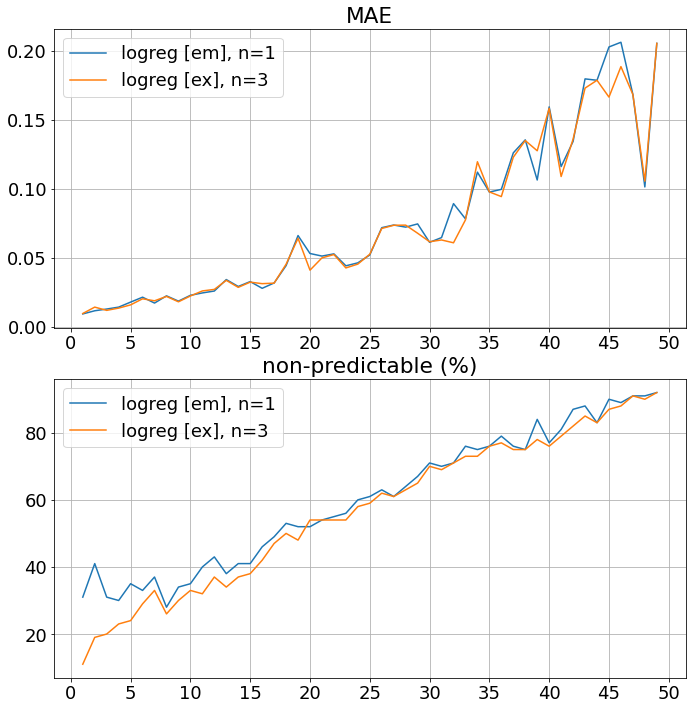

In [ ]:
deamons = [(sf_lin[2], 'logreg [em], n=1'),  
            (sf_lin_ex[2], 'logreg [ex], n=3'),
]
get_metrics(deamons, x_test)

### Сравнение [lp], [ex] и [lp, ex]

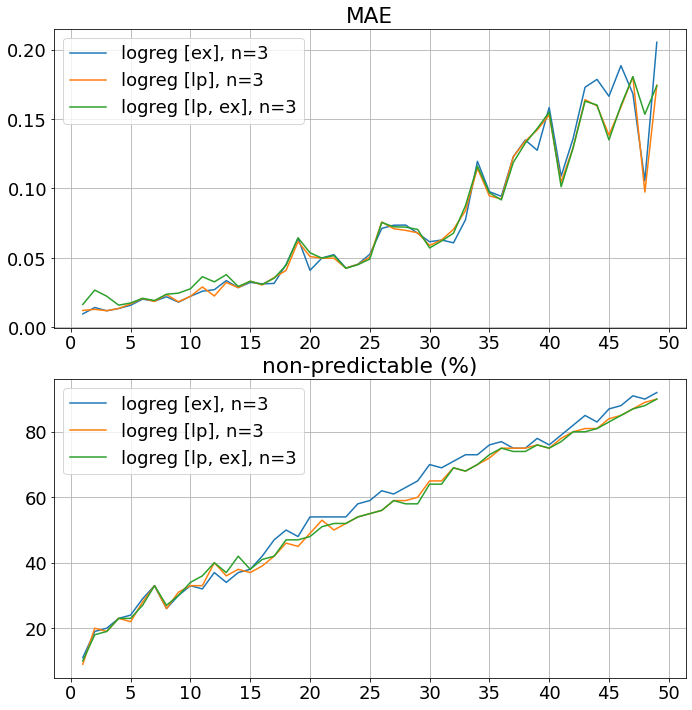

In [ ]:
deamons = [(sf_lin_ex[2], 'logreg [ex], n=3'),
            (sf_lin_lp[2], 'logreg [lp], n=3'),  
            (sf_lin_lp_ex[2], 'logreg [lp, ex], n=3'),  
]
get_metrics(deamons, x_test)

### Сравнение [p] и [cl]

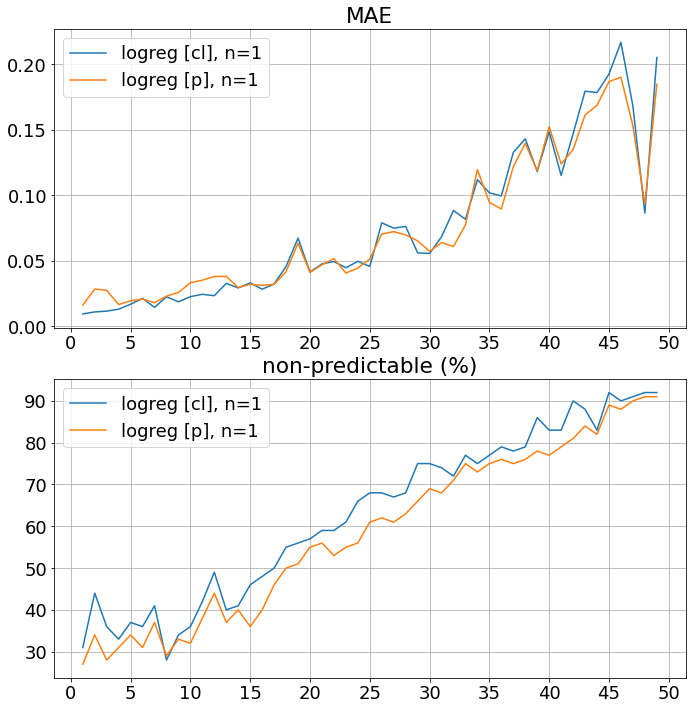

In [ ]:
deamons = [(sf_lin[0], 'logreg [cl], n=1'),
            (sf_p, 'logreg [p], n=1')
]
get_metrics(deamons, x_test)

### Сравнение [all] и [np]

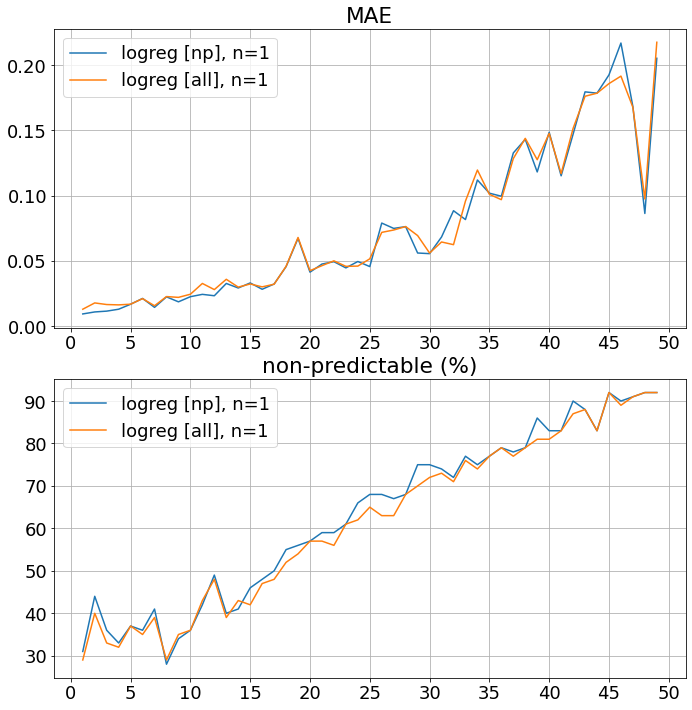

In [ ]:
deamons = [(sf_lin[0], 'logreg [np], n=1'),
            (sf_lin_all[0], 'logreg [all], n=1')
]
get_metrics(deamons, x_test)

### Дополнительно

#### Итерации [ex]

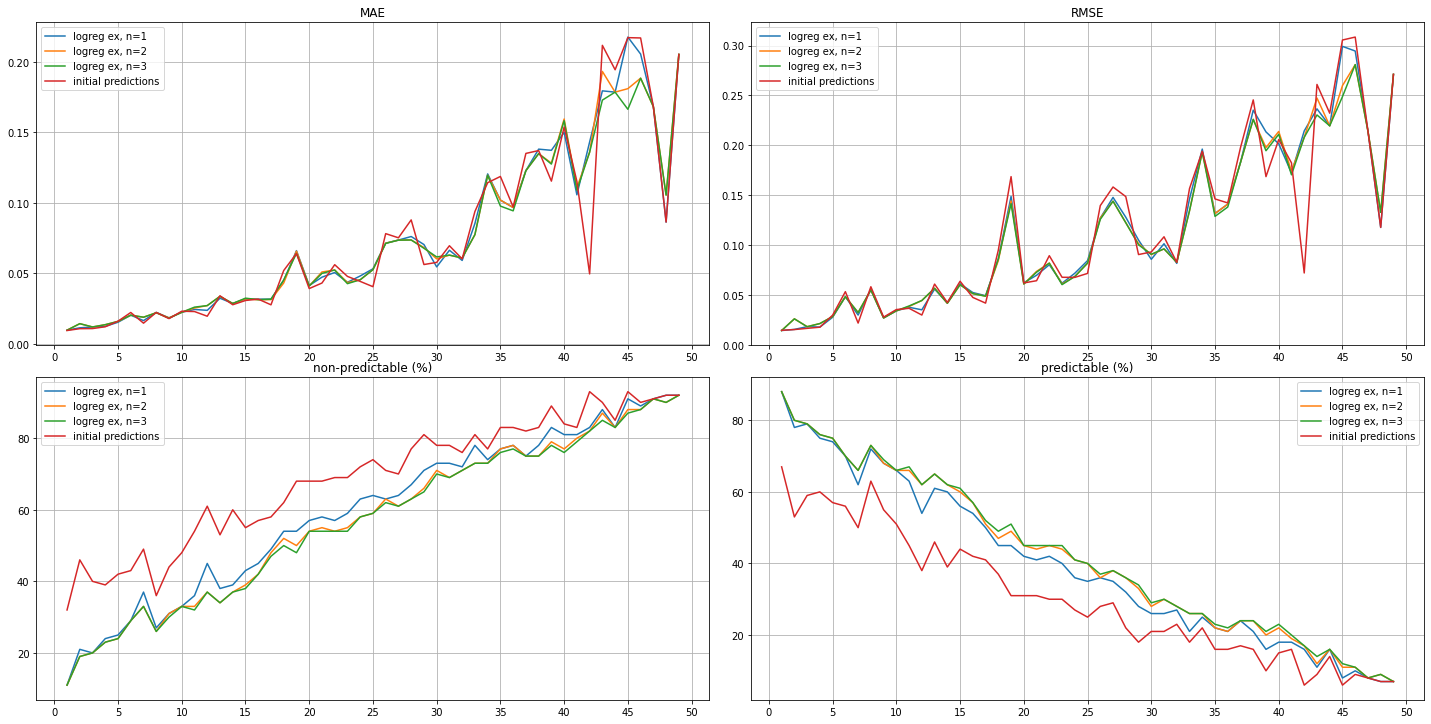

In [ ]:
deamons = [(sf_lin_ex[0], 'logreg ex, n=1'),  
            (sf_lin_ex[1], 'logreg ex, n=2'),
            (sf_lin_ex[2], 'logreg ex, n=3'),  
            (init_demon, "initial predictions")
]
lin_metrics = get_metrics(deamons, x_test, True)

#### Итерации [em]

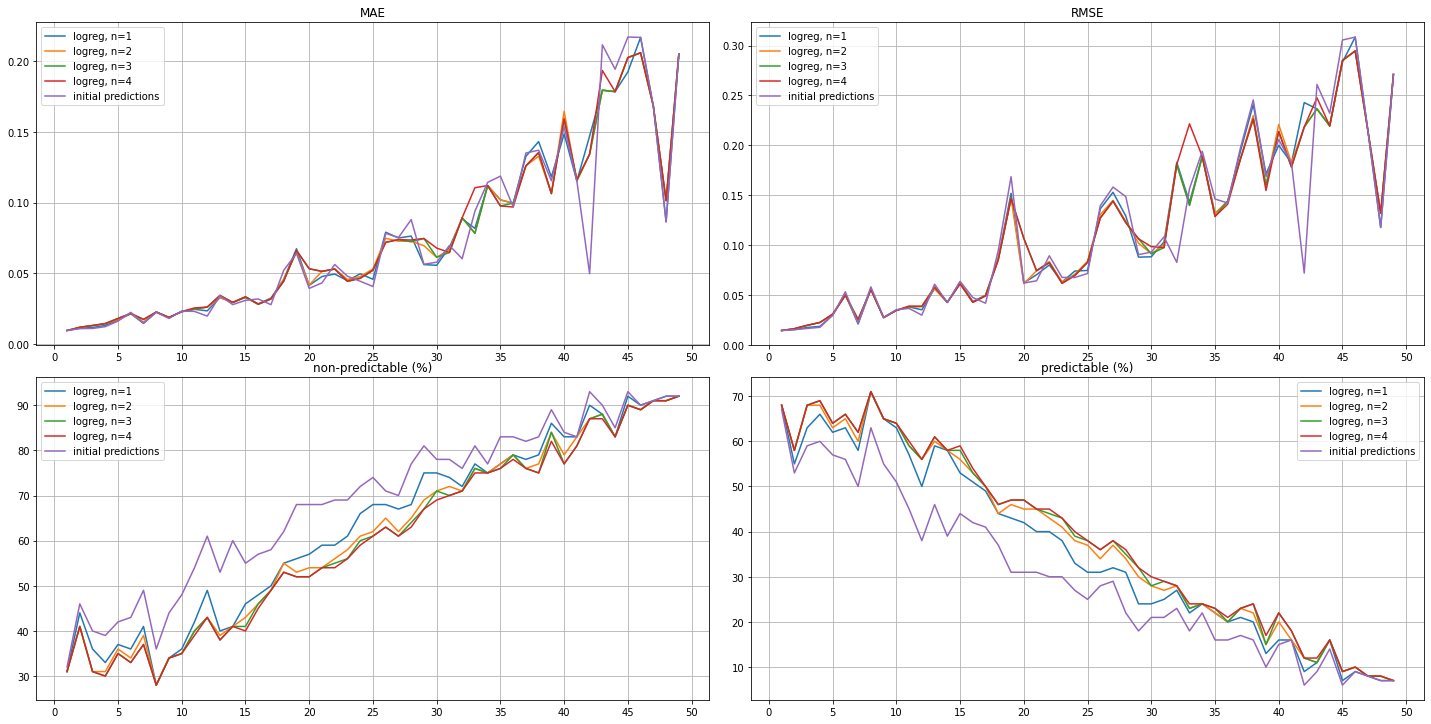

In [ ]:
deamons = [(sf_lin[0], 'logreg, n=1'),  
            (sf_lin[1], 'logreg, n=2'),
            (sf_lin[2], 'logreg, n=3'),
            (sf_lin[3], 'logreg, n=4'),    
           (init_demon, "initial predictions")
]
lin_metrics = get_metrics(deamons, x_test, True)

# Численные результаты

In [ ]:
deamons = [(init_demon, 'initial predictions'),
              (sf_ideal3, 'sf ideal, n=3'),
              (sf_simple, 'sf_simple, n=1'),
              (sf_lin_ex[2], 'logreg [ex], n=3'),
              (sf_lin[2], 'logreg [em], n=3'),
              (sf_lin_lp_ex[2], 'logreg [ex, lp], n=3'),
              (sf_p, 'logreg [p], n=1'),
              (sf_lin_all[0], 'logreg [all], n=1'),
              (sf_lin[0], 'logreg, n=1'), 
              (sf_lin_lp[2], 'logreg, n=3'),  
              (sf_svm_lp[2], 'svm, n=3'),
              (sf_dt_lp[2], 'decision tree, n=3'),
              (sf_mlp_lp[2], 'mlp, n=3'),
              (sf_tr, 'FTTransformer, n=3'),
              (sf_ada_boost_lin[-1], 'ada boost logreg, n=3'),                 
              (sf_ada_boost_svm[-1], 'ada boost svm, n=3'),
              (sf_cb_lp[-1], 'cat boost, n=3'),
              (sf_stacking[-1], 'stacking, n=3'),  
              (sf_knn_lp[2], 'knn, n=3'),
              (sf_lin_lp[6], 'logreg, n=7'), 

]
             
res = get_metrics(deamons, x_test, return_values=True, plot=False)

In [ ]:
for i in range(len(deamons)):
  print(res[0][i][1], ":")
  print("%.3f" %(res[0][i][0][1]), "- %.3f" %(res[1][i][0][1]), "- %.0f" %(res[-1][i][0][1]))
  print()

initial predictions :
0.010 - 0.015 - 32

sf ideal, n=3 :
0.010 - 0.016 - 28

sf_simple, n=1 :
0.018 - 0.040 - 25

logreg [ex], n=3 :
0.010 - 0.014 - 11

logreg [em], n=3 :
0.009 - 0.014 - 31

logreg [ex, lp], n=3 :
0.017 - 0.032 - 10

logreg [p], n=1 :
0.016 - 0.037 - 27

logreg [all], n=1 :
0.013 - 0.027 - 29

logreg, n=1 :
0.009 - 0.014 - 31

logreg, n=3 :
0.012 - 0.023 - 9

svm, n=3 :
0.032 - 0.087 - 19

decision tree, n=3 :
0.028 - 0.089 - 26

mlp, n=3 :
0.032 - 0.102 - 24

FTTransformer, n=3 :
0.010 - 0.015 - 30

ada boost logreg, n=3 :
0.022 - 0.046 - 22

ada boost svm, n=3 :
0.033 - 0.102 - 23

cat boost, n=3 :
0.034 - 0.104 - 24

stacking, n=3 :
0.037 - 0.108 - 22

knn, n=3 :
0.033 - 0.101 - 22

logreg, n=7 :
0.012 - 0.023 - 9



In [ ]:
for i in range(len(deamons)):
  print(res[0][i][1], ":")
  print("%.3f" %(res[0][i][0][15]), "- %.3f" %(res[1][i][0][15]), "- %.0f" %(res[-1][i][0][15]))
  print()

initial predictions :
0.031 - 0.064 - 55

sf ideal, n=3 :
0.029 - 0.057 - 42

sf_simple, n=1 :
0.034 - 0.061 - 37

logreg [ex], n=3 :
0.032 - 0.060 - 38

logreg [em], n=3 :
0.033 - 0.061 - 41

logreg [ex, lp], n=3 :
0.033 - 0.061 - 38

logreg [p], n=1 :
0.032 - 0.060 - 36

logreg [all], n=1 :
0.032 - 0.061 - 42

logreg, n=1 :
0.033 - 0.063 - 46

logreg, n=3 :
0.033 - 0.060 - 37

svm, n=3 :
0.040 - 0.068 - 32

decision tree, n=3 :
0.034 - 0.062 - 37

mlp, n=3 :
0.037 - 0.068 - 45

FTTransformer, n=3 :
0.033 - 0.062 - 43

ada boost logreg, n=3 :
0.033 - 0.059 - 35

ada boost svm, n=3 :
0.037 - 0.067 - 45

cat boost, n=3 :
0.040 - 0.068 - 35

stacking, n=3 :
0.036 - 0.065 - 42

knn, n=3 :
0.037 - 0.067 - 43

logreg, n=7 :
0.033 - 0.060 - 37



In [ ]:
for i in range(len(deamons)):
  print(res[0][i][1], ":")
  print("%.3f" %(res[0][i][0][30]), "- %.3f" %(res[1][i][0][30]), "- %.0f" %(res[-1][i][0][30]))
  print()

initial predictions :
0.058 - 0.093 - 78

sf ideal, n=3 :
0.050 - 0.083 - 72

sf_simple, n=1 :
0.066 - 0.097 - 64

logreg [ex], n=3 :
0.062 - 0.091 - 70

logreg [em], n=3 :
0.061 - 0.091 - 71

logreg [ex, lp], n=3 :
0.057 - 0.085 - 64

logreg [p], n=1 :
0.057 - 0.087 - 69

logreg [all], n=1 :
0.056 - 0.086 - 72

logreg, n=1 :
0.056 - 0.088 - 75

logreg, n=3 :
0.059 - 0.086 - 65

svm, n=3 :
0.086 - 0.144 - 55

decision tree, n=3 :
0.074 - 0.114 - 61

mlp, n=3 :
0.096 - 0.157 - 59

FTTransformer, n=3 :
0.060 - 0.095 - 71

ada boost logreg, n=3 :
0.072 - 0.109 - 57

ada boost svm, n=3 :
0.087 - 0.140 - 63

cat boost, n=3 :
0.094 - 0.145 - 63

stacking, n=3 :
0.077 - 0.123 - 65

knn, n=3 :
0.073 - 0.116 - 66

logreg, n=7 :
0.062 - 0.088 - 60



# Итерации логрега

In [ ]:
for i in range(4):
  sf_lin_lp.append(apply_sf_ml(X_lin, y_lin, 1, best_classifiers[0][0], lin_stats, lin_scaler, last_p=True, init=sf_lin_lp[-1])[0])

100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


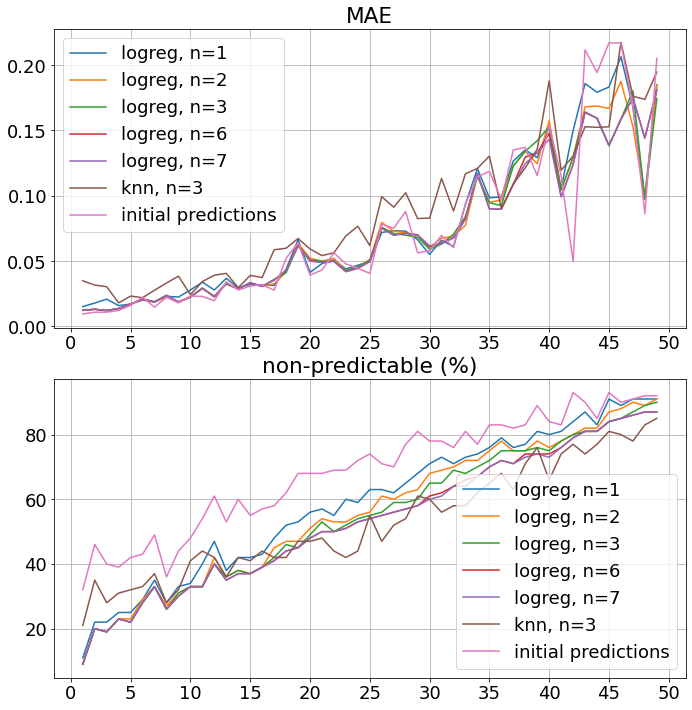

In [ ]:
deamons = [(sf_lin_lp[0], 'logreg, n=1'),  
           (sf_lin_lp[1], 'logreg, n=2'),
           (sf_lin_lp[2], 'logreg, n=3'),
           #(sf_lin_lp[3], 'logreg, n=4'),
           #(sf_lin_lp[4], 'logreg, n=5'),
           (sf_lin_lp[5], 'logreg, n=6'),
           (sf_lin_lp[6], 'logreg, n=7'),
           (sf_knn_lp[-1], 'knn, n=3'),
           (init_demon, "initial predictions")
]

plt.rcParams.update({'font.size': 18})
get_metrics(deamons, x_test)

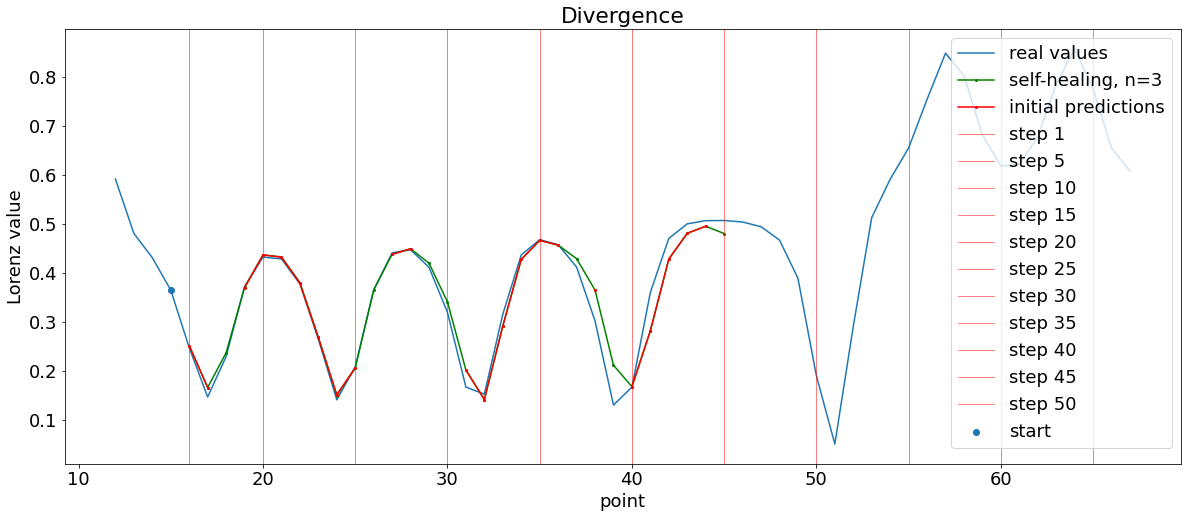

In [115]:
plt.rcParams.update({'font.size': 18})
visualize_point([(sf_lin_lp[-1], 'self-healing, n=3'), (init_demon, 'initial predictions')], 
                15, 
                real_vals=x_test
                )

## Сравнение с logreg [p]

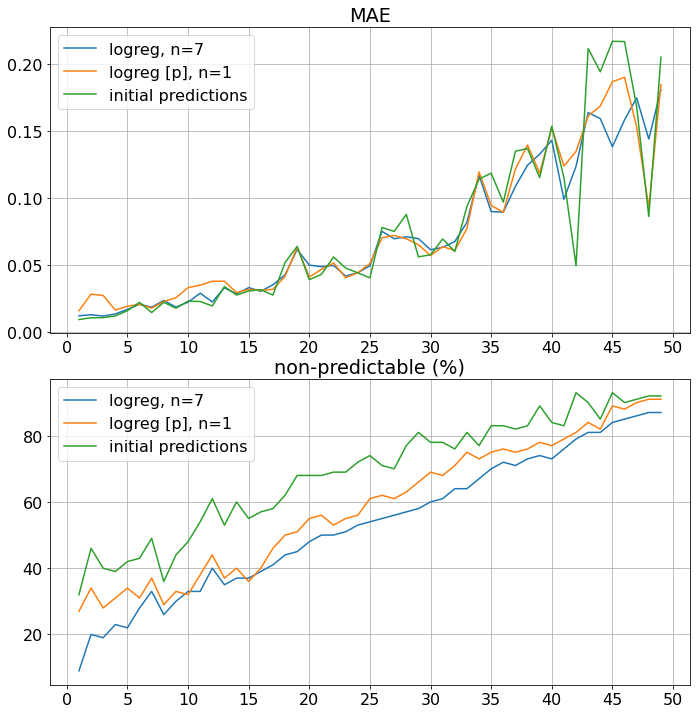

In [ ]:
deamons = [(sf_lin_lp[6], 'logreg, n=7'),
           (sf_p, 'logreg [p], n=1'),
           (init_demon, "initial predictions")
]

plt.rcParams.update({'font.size': 16})
get_metrics(deamons, x_test)